# LAB 1: Digital Sampling, Fourier Filtering, and Heterodyne Mixers in Radio Astronomy

In [1]:
from __future__ import annotations

import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

LAB_DIR = Path.cwd()
SRC_DIR = LAB_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from ugradio_lab1.analysis import *
from ugradio_lab1.experiment import *
from ugradio_lab1.pipeline import *
from ugradio_lab1.plotting import *
from ugradio_lab1.sim import *

apply_lab_style()

FIG_DIR = LAB_DIR / "report" / "figures"

SEED = 20260208
RNG = np.random.default_rng(SEED)

In [2]:
# Build unified catalog from all raw experiment data
CATALOG_PARQUET = LAB_DIR / "data" / "processed" / "unified_catalog.parquet"

catalog = build_unified_catalog()
qc = build_unified_qc_catalog(catalog)
write_catalog_parquet(qc, CATALOG_PARQUET)


PosixPath('/Users/junruiting/GitHub/ugradio/labs/01/data/processed/unified_catalog.parquet')

## Abstract

This report presents a systematic investigation of digital sampling, spectral analysis, and heterodyne mixing using a software-defined radio (SDR) receiver built around an RTL2832U ADC and R820T tuner. Seven experiments validate core concepts through a simulation-first methodology where every measurement is cross-checked against matched numerical predictions before acceptance. Nyquist sampling theory is confirmed with alias-frequency residuals of median 21 Hz (E1), well within the frequency-bin resolution of 24–49 Hz depending on sample rate. The SDR bandpass is characterized across 1.0–3.2 MHz sample rates, revealing effective passband widths of 412–983 kHz and demonstrating that the alias-hack FIR mode provides sharper spectral edges at the cost of reduced bandwidth (E2). Voltage and power spectral representations are validated against Parseval's theorem with relative energy errors below 0.1% (E3). Spectral leakage and frequency resolution are quantified as functions of record length and window function, with measured main-lobe widths and sidelobe levels matching theoretical predictions within ±0.5 dB (E4). Noise statistics from a laboratory generator follow Gaussian distributions with measured kurtosis 2.97±0.08, and block-averaged power variance obeys the radiometer equation with fitted slope −0.478 ($R^2 = 0.986$), close to the theoretical −0.5 (E5). Double-sideband (DSB) mixer simulations identify expected sum and difference frequency products with catalogued intermodulation families up to first order (E6). Single-sideband (SSB) IQ phasing demonstrates sideband discrimination with USB and LSB in simulation (E7). All analysis is implemented in the installable `ugradio_lab1` Python package with SDR and signal generator wrapper drivers, quality-control flagging, and unit tests ensuring reproducibility.

## 1. Introduction

Digital sampling and Fourier spectral analysis form the observational backbone of modern radio astronomy. All electronic devices that interface with an analog signal (of particular interest, radio telescopes) digitizes the sky signal at a finite sample rate, imposing a Nyquist frequency ceiling and introducing aliasing artifacts that must be understood and controlled. The discrete Fourier transform (DFT) converts time-domain voltage signals into frequency-domain spectra, but finite record lengths introduce spectral leakage and resolution limits that imposes practical limitations on what can be reliably measured. Before any astronomical source can be detected, these instrumental effects must be characterized.

Heterodyne mixing extends the reach of digital receivers by translating and downconverting high-frequency radio signals into a lower intermediate-frequency (IF) band where they can be sampled by affordable ADCs (such as the one we are using, allegedly repurposed from TV channel piracy modules). Double-sideband (DSB) mixers produce both sum and difference frequency products, while single-sideband (SSB) architectures use quadrature (IQ) phasing to discriminate between upper and lower sidebands. Characterizing these mixing products and any side-effect intermodulations is essential for being able to understand and produce any real receiver output.

This report adopts a “mistrust everything” philosophy: every measurement is cross-checked against a matched simulation before being accepted. The experimental platform is an RTL-SDR dongle (RTL2832U ADC with a R820T tuner, though sadly due to time constraints we will not be characterizing the tuner) connected to a Raspberry Pi, with external signal generators (primarily N9310A and DS345) and mixers (ZAD-1) providing controlled RF inputs. Seven experiments systematically build from sampling fundamentals through spectral and noise characterization, to mixer operation.

The report is organized as follows. Section 2 develops the theory and simulation framework. Section 3 describes the hardware, calibration protocol, and data pipeline. Section 4 presents results and analysis for each experiment (E1–E7). Section 5 synthesizes findings across experiments, Section 6 concludes with a summary of validated results and their connection to upcoming 21-cm line observations, Section 7 documents reproducibility details, and Section 8 lists references.

## 2. Theory and Modeling Framework

This section lays out the mathematical framework that underpins all seven experiments in this report. We begin with the wave superposition principle and the Fourier transform and its discrete implementation, a description of digital sampling, aliasing, spectral leakage and windowing, and finally heterodyne mixer equations. Each mathematical description is paired with a short simulation that demonstrates the result numerically before it is applied to hardware data in Section 4.

### 2.1 Waves and Superposition

A sinusoidal voltage waveform is modeled as
$$f(t)=A\cos(2\pi f_0 t + \phi).$$
If two waves propagate together, the resultant signal is additive:
$$f(t)=f_1(t)+f_2(t).$$
Suppose 2 nearby tones are played (with same amplitude and phase for simplicity),
$$\cos(2\pi f_1 t)+\cos(2\pi f_2 t)
=2\cos\!\left(2\pi\frac{f_1-f_2}{2}t\right)
\cos\!\left(2\pi\frac{f_1+f_2}{2}t\right),$$
which results in a beat envelope at $|f_1-f_2|$ with another signal at $(f_1+f_2)/2$ (see Figure 1).

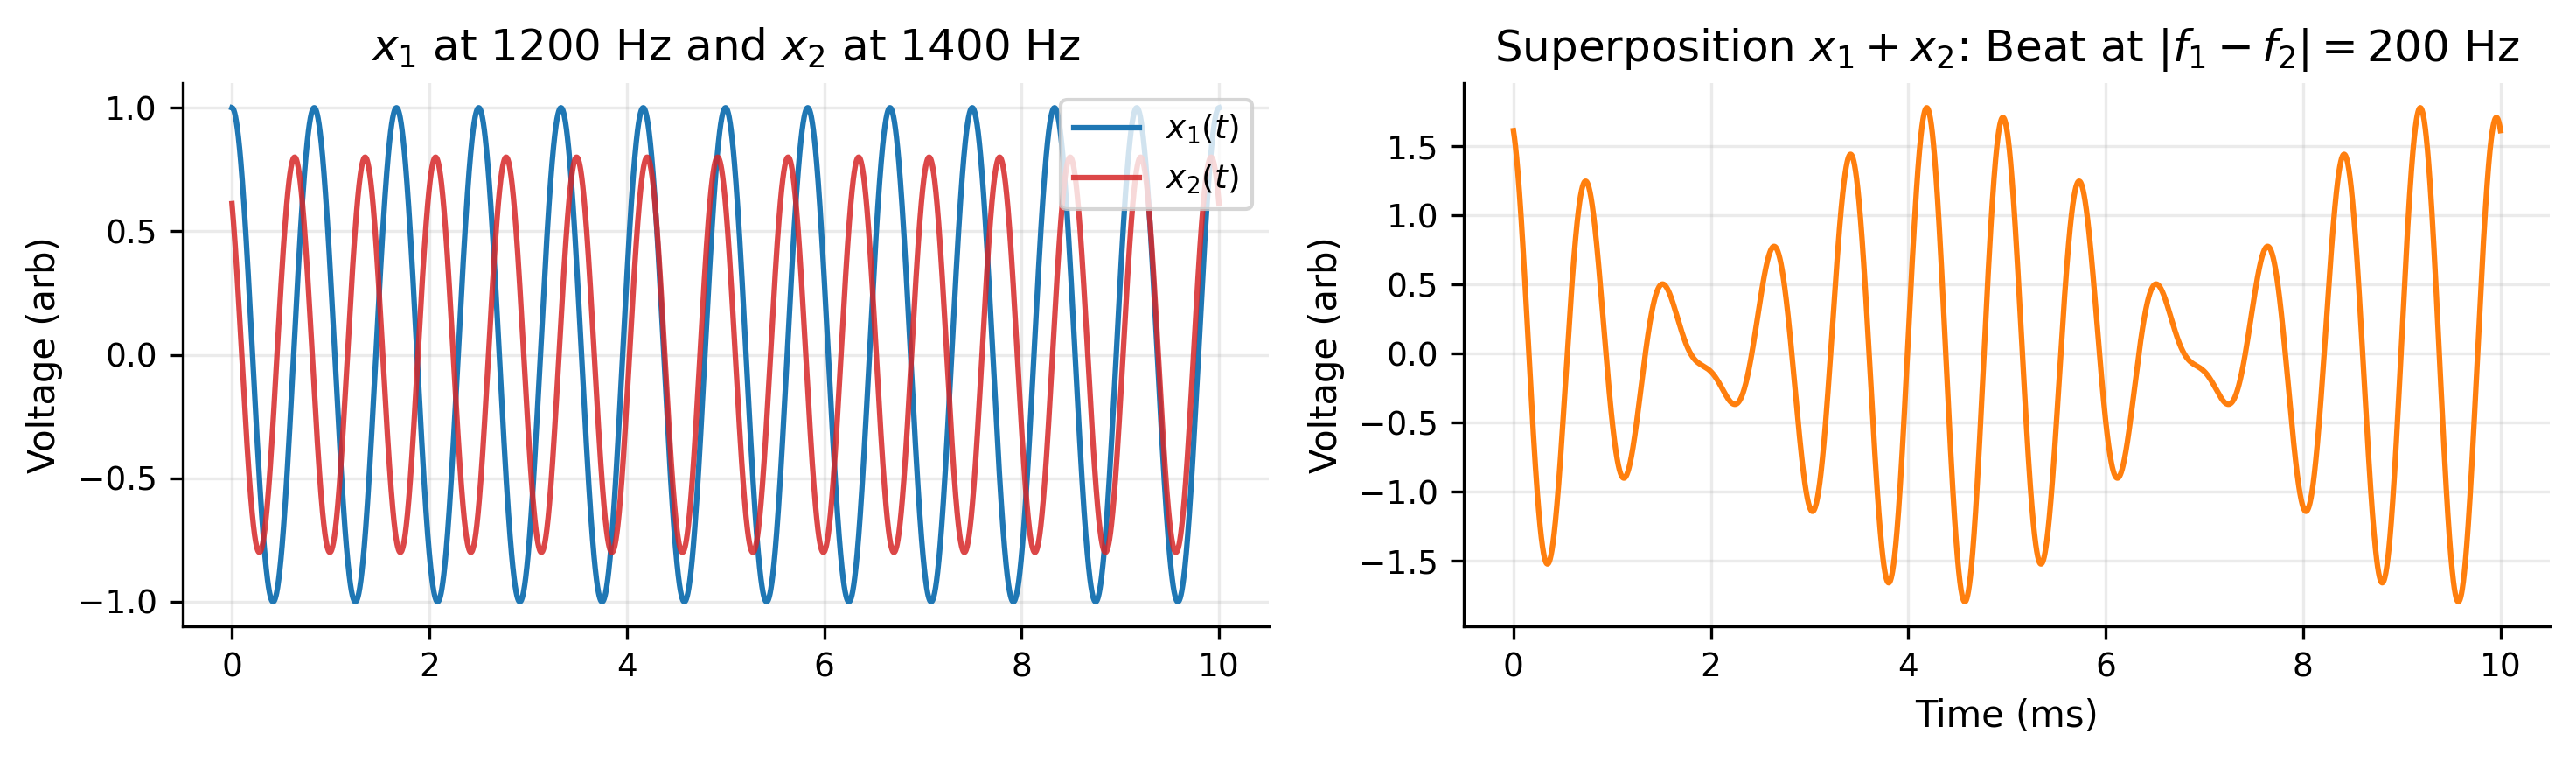

In [3]:
# THEORY_DEMO: Waves and superposition (beats)
f1_hz, f2_hz = 1200.0, 1400.0
t_s = np.linspace(0.0, 0.01, 4000)
x1 = np.cos(2.0 * np.pi * f1_hz * t_s)
x2 = 0.8 * np.cos(2.0 * np.pi * f2_hz * t_s + 0.7)
x_sum = x1 + x2

fig, _ = plot_theory_beats(t_s, x1, x2, x_sum, f1_hz=f1_hz, f2_hz=f2_hz)
plt.show()

**Figure 1.** *(Left)* Two sinusoidal voltage waveforms $f_1(t)$ at $f_1=1200\;\mathrm{Hz}$ and $f_2(t)$ at $f_2=1400\;\mathrm{Hz}$ with different amplitudes and a relative phase offset. *(Right)* Their superposition $f(t)=f_1(t)+f_2(t)$, showing the characteristic beat envelope at $|f_1-f_2|=200\;\mathrm{Hz}$ modulating a carrier at $(f_1+f_2)/2=1300\;\mathrm{Hz}$.

### 2.2 Fourier Analysis

#### 2.2a Mathematical definitions and energy relations
Before we continue with the more physical relations, we begin we some necessary mathematical definitions.

The continuous-time Fourier transform pair is
$$\hat{f}(\omega)=\mathcal{F}\{f(t)\}(\omega)=\int_{-\infty}^{\infty} f(t)e^{-i\omega t}\,dt,
\qquad
f(t)=\mathcal{F}^{-1}\{\hat{f}(\omega)\}(t)=\frac{1}{2\pi}\int_{-\infty}^{\infty}\hat{f}(\omega)e^{i\omega t}\,d\omega.$$

Parseval's theorem (continuous form):
$$\int_{-\infty}^{\infty}|f(t)|^2\,dt = \frac{1}{2\pi}\int_{-\infty}^{\infty}|\hat{f}(\omega)|^2\,d\omega.$$
So total signal energy is invariant under transform-domain representation.

For a finite sampled record, with DFT as defined above, the discrete Parseval relation becomes
$$\sum_{n=0}^{N-1}|f[n]|^2 = \frac{1}{N}\sum_{k=0}^{N-1}|\hat{f}[k]|^2.$$
Dividing by $N$ yields mean-square voltage:
$$\frac{1}{N}\sum_n |f[n]|^2 = \sum_k \frac{|\hat{f}[k]|^2}{N^2}.$$

When the time-domain signal $f[n]$ is real-valued (as in most SDR measurements), the Fourier transform exhibits Hermitian symmetry: $\hat{f}[k] = \hat{f}^*[N-k]$ for $k = 1, 2, \ldots, N-1$. This implies that the magnitude spectrum is symmetric about $f_s/2$: $|\hat{f}[k]| = |\hat{f}[N-k]|$, while the imaginary spectrum is antisymmetric: $\arg(\hat{f}[k]) = -\arg(\hat{f}[N-k])$. Equivalently, the real component of the voltage spectrum is even-symmetric, and the imaginary component is odd-symmetric about the zero-frequency bin. This symmetry allows us to fully reconstruct the spectrum from just the bins $k=0$ to $k=N/2$, corresponding to the principal Nyquist interval $[0, f_s/2)$. For complex-valued signals (e.g., IQ data from a mixer with independent I and Q channels), Hermitian symmetry will not hold, and positive and negative frequency components can carry distinct information, which together can still allow us to reconstruct the original signal.

#### 2.2b Practical spectral quantities in this lab

The **voltage spectrum** is the complex-valued DFT output $\hat{f}[k]$, retaining both amplitude and phase information needed for IQ demodulation and mixer product identification (E6, E7). The **power spectrum** is the non-negative per-bin energy estimate,
$$P[k]=\frac{|\hat{f}[k]|^2}{N^2},$$
which enables line-strength comparison and energy accounting. Dividing by the resolution bandwidth $\Delta f = f_s/N$ yields the **power spectral density** (PSD) in units of power per hertz. In practice, E3 uses voltage and power spectra jointly, E5 uses power spectra and ACF consistency to validate noise statistics, and E6– E7 use spectral line placement to identify mixing products and effects (see Figure 2).

Parseval's theorem check (mean signal power must equal sum of per-bin spectral power):
  Time-domain  mean(x²)        = 9.650000e-01
  Freq-domain  Σ|Xₖ/N|²       = 9.650000e-01
  Relative error                = 2.301e-16
  Match: PASS (numerical threshold 1e-10)


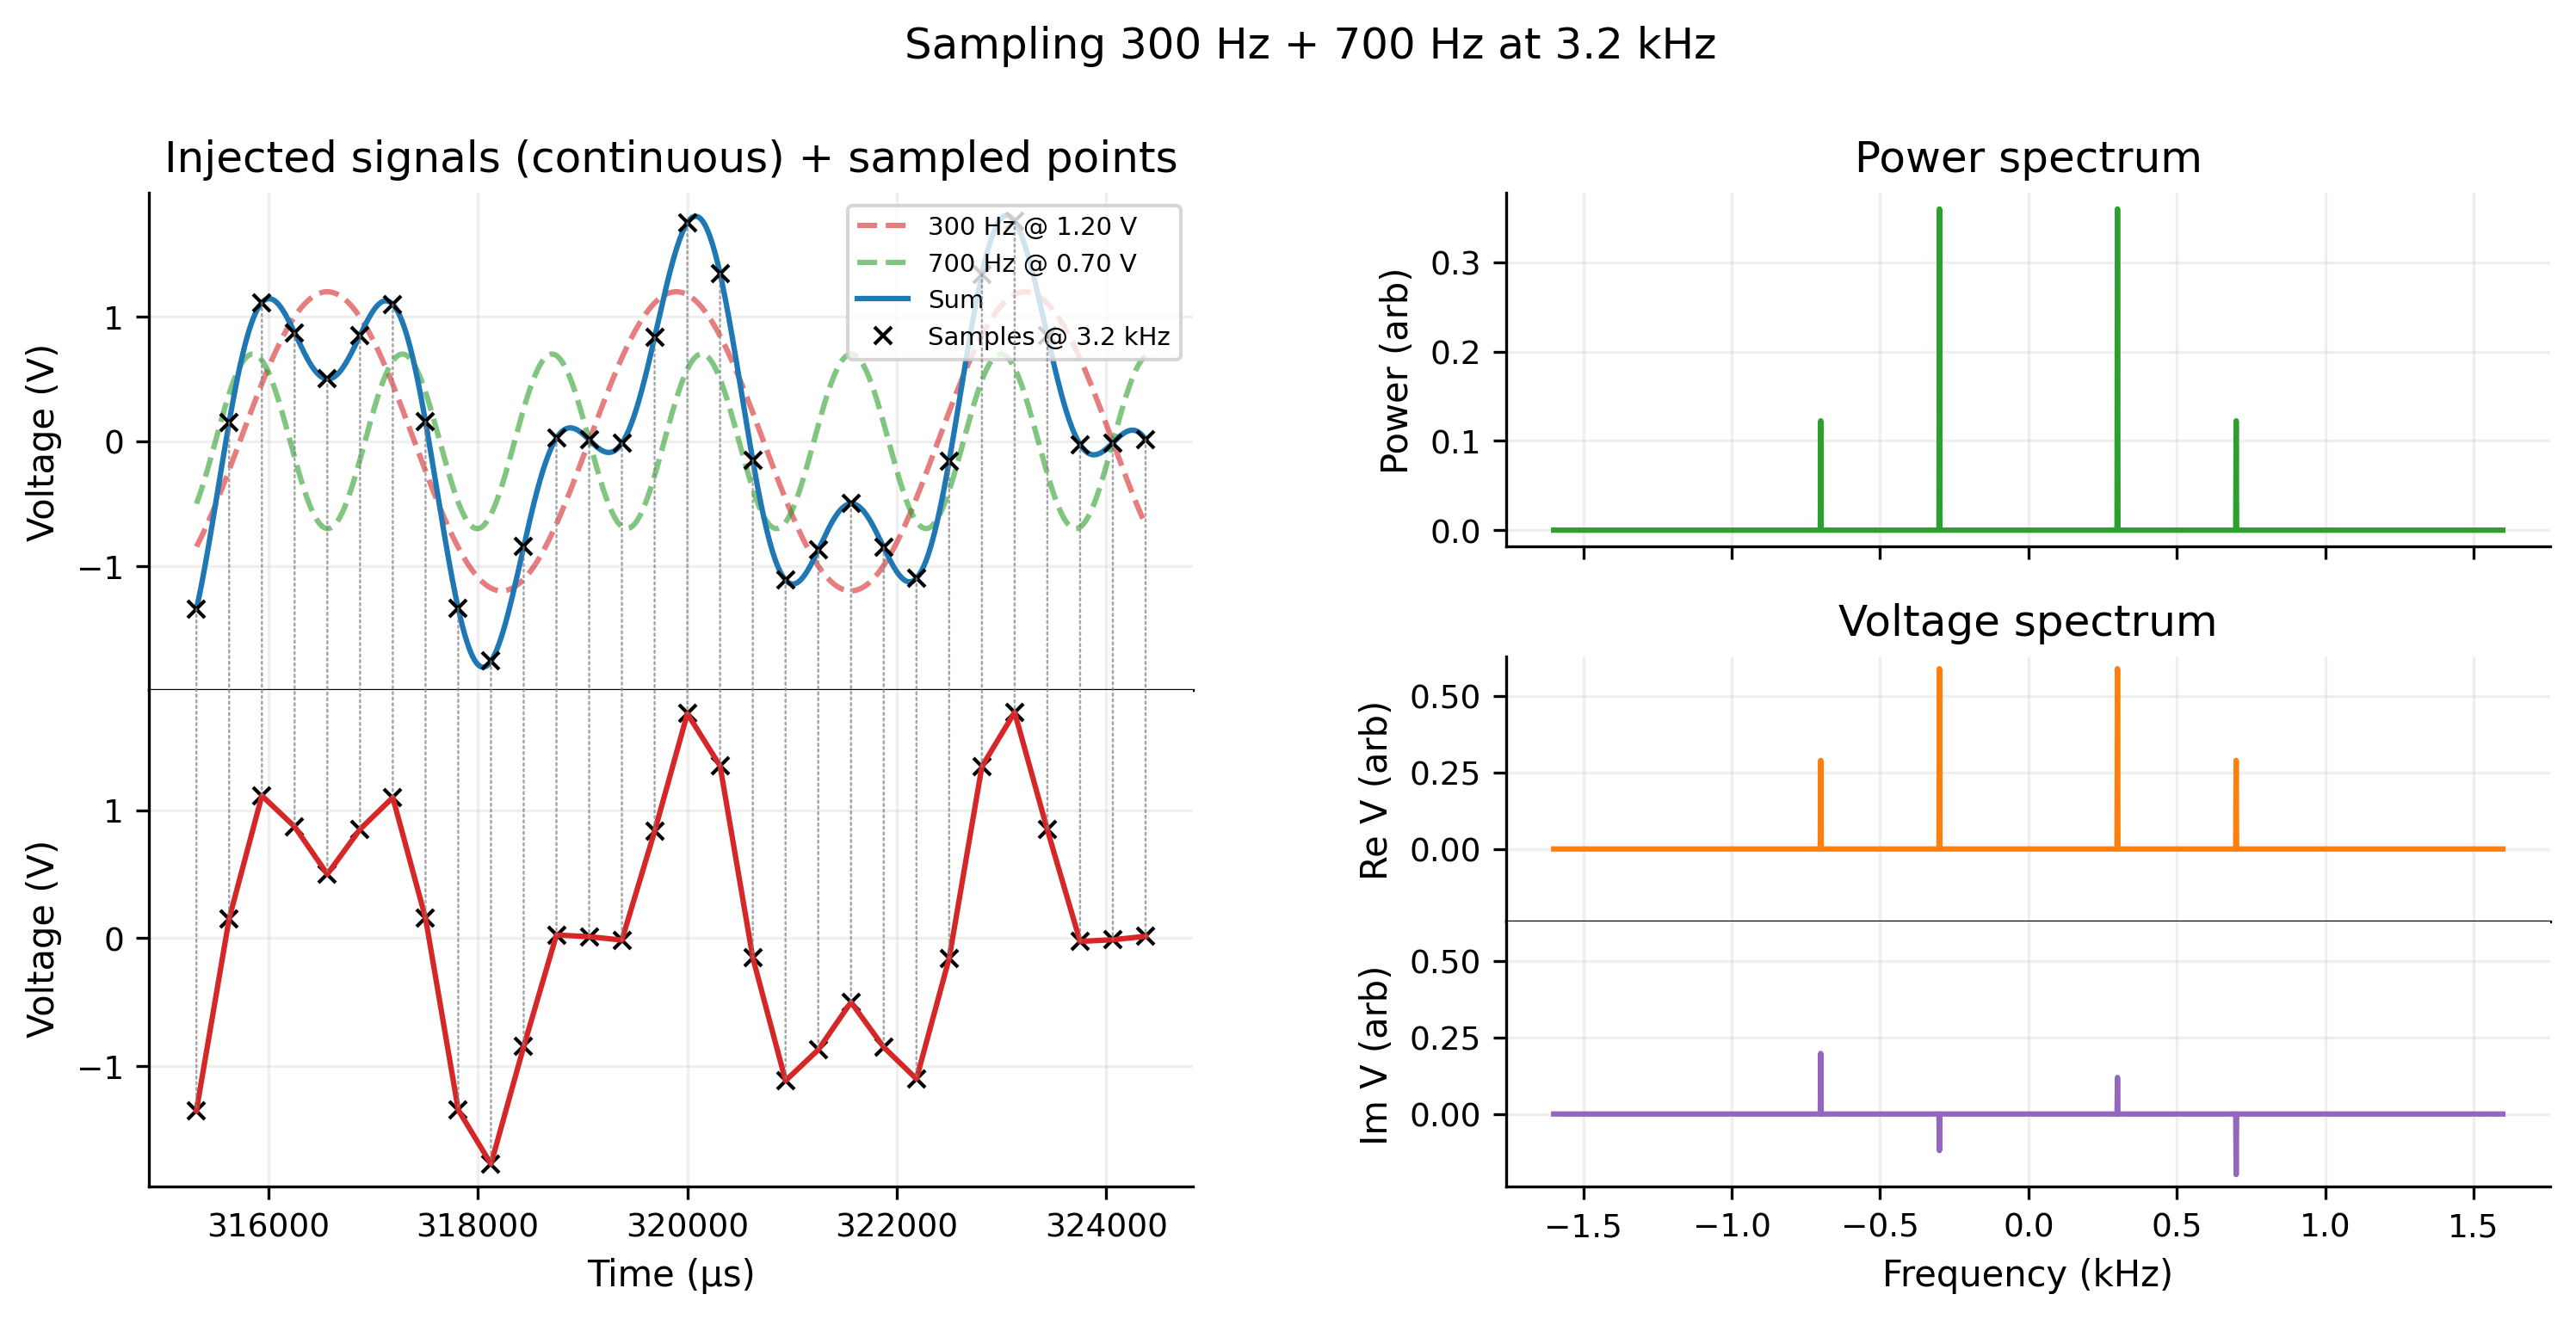

In [4]:
# THEORY_DEMO: Fourier decomposition, voltage spectrum, power spectrum, Parseval check
fs_hz = 3200.0
n_samples = 2048
t_s = np.arange(n_samples) / fs_hz
f1, f2 = 300.0, 700.0
a1, a2 = 1.20, 0.70
x = a1 * np.cos(2.0 * np.pi * f1 * t_s + 0.2) + a2 * np.cos(2.0 * np.pi * f2 * t_s - 0.6)

X = np.fft.fftshift(np.fft.fft(x))
f_hz = np.fft.fftshift(np.fft.fftfreq(n_samples, d=1.0 / fs_hz))
voltage_real = np.real(X) / n_samples
voltage_imag = np.imag(X) / n_samples
power_bin = (voltage_real**2 + voltage_imag**2)

parseval_time = np.mean(x**2)
parseval_freq = np.sum(power_bin)
rel_err = abs(parseval_time - parseval_freq) / max(parseval_time, 1e-15)
print(f"Parseval's theorem check (mean signal power must equal sum of per-bin spectral power):")
print(f"  Time-domain  mean(x²)        = {parseval_time:.6e}")
print(f"  Freq-domain  Σ|Xₖ/N|²       = {parseval_freq:.6e}")
print(f"  Relative error                = {rel_err:.3e}")
print(f"  Match: {'PASS' if rel_err < 1e-10 else 'FAIL'} (numerical threshold 1e-10)")

fig, _ = plot_theory_fourier(
    t_s, x, f_hz, voltage_real, voltage_imag, power_bin,
    fs_hz=fs_hz, f1=f1, f2=f2, a1=a1, a2=a2,
)
plt.show()

**Figure 2.** *(Left)* Continuous injected waveforms (300 Hz and 700 Hz components, dashed) and their sum (solid blue) with discrete sample points (black crosses) at $f_s = 3200$ Hz. The bottom panel shows only the sampled sequence with connecting lines. *(Right)* Power spectrum (top) shows peaks at $\pm 300$ Hz and $\pm 700$ Hz. The voltage spectrum (bottom) is decomposed into real and imaginary components, preserving the phase information lost in the power representation. Parseval's theorem is satisfied to numerical precision. Note the Hermitian symmetry exhibited by the complex voltage spectrum: the real part is even-symmetric, and the imaginary part is odd-symmetric, which is a result of the time-domain signal being real-valued.

### 2.3 Digital Sampling, Aliasing, Nyquist Frequency, and Nyquist Zones

Sampling maps a continuous-time signal to a sequence:
$$f[n] = f_c(nT_s), \qquad T_s = 1/f_s.$$
For a tone $f_c(t)=A\exp(i\omega_0 t)$ with $\omega_0 = 2\pi f_0$,
$$f[n]=A\exp\!\left(i\,\omega_0 nT_s\right)=A\exp\!\left(i2\pi (f_0/f_s)n\right).$$
Because discrete-time frequency is $2\pi$-periodic, $f_0$ and $f_0 + m f_s$ are indistinguishable in sampled data ($m\in\mathbb{Z}$). This is aliasing!

The principal Nyquist interval is $[0, f_s/2)$ and the boundary to this principal Nyquist interval is the Nyquist frequency: $f_N=f_s/2$. Frequencies outside the principal interval "fold" into this interval, and we report the folded unsigned alias magnitude.
$$f_{\text{alias}} = \left((f_{\text{true}}+f_s/2)\bmod f_s\right)-f_s/2.$$

Figure 3 demonstrates this: the left panel shows the full aliasing map, while the right panel uses the power spectrum (introduced in Section 2.2) to confirm that a 300 Hz and a 1300 Hz tone are spectrally indistinguishable when sampled at $f_s=1000\;\mathrm{Hz}$.

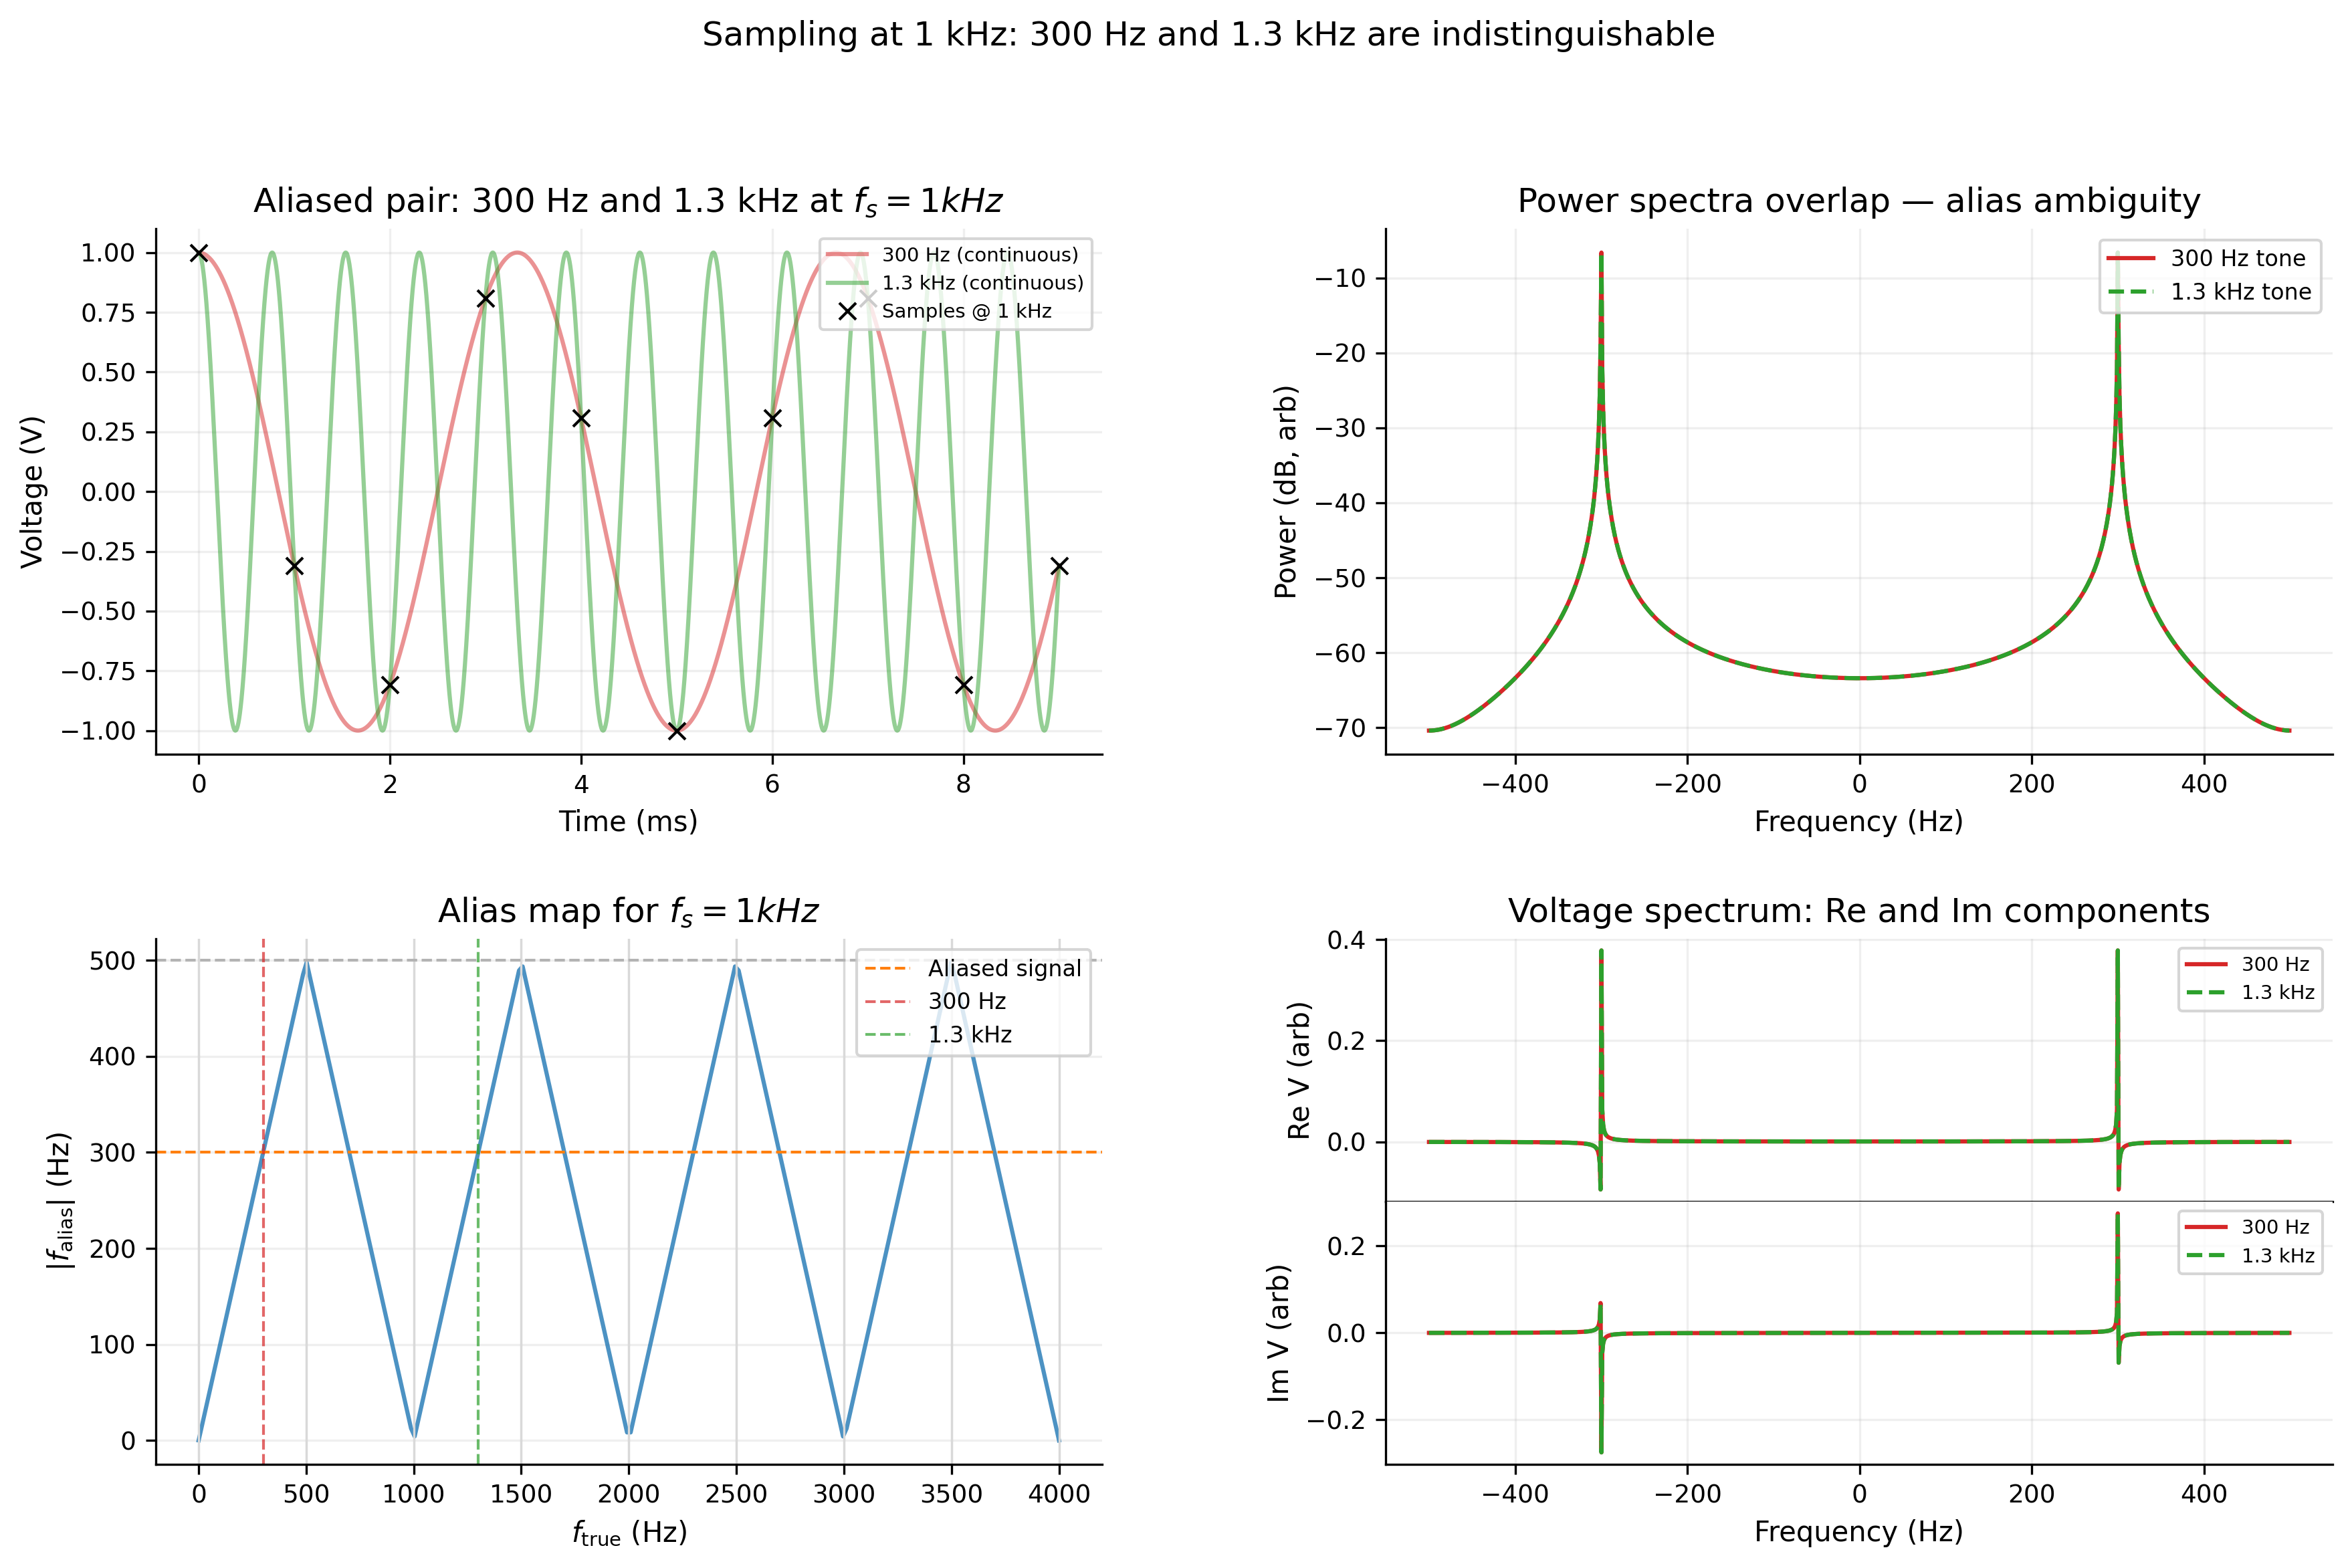

In [5]:
# THEORY_DEMO: Aliasing — two tones that are indistinguishable after sampling
fs_hz = 1000.0
f_low_hz, f_high_hz = 300.0, 1300.0   # differ by f_s

n_samples = 1024
t_s = np.arange(n_samples) / fs_hz

x_low  = np.cos(2.0 * np.pi * f_low_hz  * t_s)
x_high = np.cos(2.0 * np.pi * f_high_hz * t_s)

X_low  = np.fft.fftshift(np.fft.fft(x_low))  / n_samples
X_high = np.fft.fftshift(np.fft.fft(x_high)) / n_samples
f_hz = np.fft.fftshift(np.fft.fftfreq(n_samples, d=1.0 / fs_hz))

f_true_sweep = np.linspace(0.0, 4000.0, 240)
f_alias_sweep = np.abs(np.mod(f_true_sweep + fs_hz / 2.0, fs_hz) - fs_hz / 2.0)

fig, _ = plot_theory_aliasing(
    f_true_sweep, f_alias_sweep, fs_hz,
    f_low_hz, f_high_hz,
    t_s, x_low, x_high, f_hz, X_low, X_high,
)
plt.show()

**Figure 3.** *(Top left)* Time-domain overlay showing that 300 Hz and 1300 Hz continuous waveforms pass through the same sample points at $f_s = 1000$ Hz. *(Bottom left)* Alias frequency map for $f_s = 1000$ Hz, with the two demonstration tones (300 Hz and 1300 Hz) marked. *(Top right)* Power spectra of both tones are identical after sampling, confirming the alias ambiguity. *(Bottom right)* Voltage spectrum decomposed into real and imaginary components, where both tones (in-phase) produce the same spectral structure, demonstrating that sampling completely destroys the distinction between frequencies separated by $f_s$. The voltage spectrum exhibits Hermitian symmetry characteristic of real-valued time-domain signals: the real component is even-symmetric about zero frequency, and the imaginary component is odd-symmetric. Sidenote, in actuality, in a discrete Fourier transform (covered in the next section), we will notice that the amplitudes for an aliased signal actually decrease in magnitude due to a finite discrete sampling window now covering full waveforms of the *faster* signal! (Consider the top left figure as a crude visualization!)

### 2.4 Discrete Transform Computation: DFT, FFT, and `ugradio.dft`

The continuous Fourier transform $\hat{f}(\nu)=\int_{-\infty}^{\infty}f(t)\,e^{-i2\pi\nu t}\,dt$ assumes an infinite, continuously sampled signal, neither of which a digital instrument can provide. An ADC delivers a *finite* number $N$ of samples at discrete times $t_n = nT_s$, so we must replace the integral with a sum and accept that only $N$ independent frequency bins can be recovered. The resulting transform is the DFT:

$$\hat{f}[k] = \sum_{n=0}^{N-1} f[n]\exp\!\left(-i\,\omega_k n\right),\qquad \omega_k=\frac{2\pi k}{N},
\qquad
f[n] = \frac{1}{N}\sum_{k=0}^{N-1} \hat{f}[k]\exp\!\left(i\,\omega_k n\right).$$

The DFT is not an approximation to the FT, it is the *exact* transform for the data we actually have. As such, its frequency grid $f_k = k f_s/N$ and resolution $\Delta f = f_s/N$ are set entirely by the sample rate and record length.

For $N$ samples, direct DFT evaluation requires $O(N^2)$ operations. FFT algorithms exploit periodicity and symmetry to reduce this to $O(N\log N)$, which is essential for the large record lengths used in this lab. All spectral computations default to `numpy.fft` for speed.

### 2.5 Convolution Theorem, Heterodyne Mixers, and FIR Filtering

**Convolution theorem**:
$$y(t)=f(t)*h(t) \Longleftrightarrow \hat{y}(\omega)=\hat{f}(\omega)\hat{h}(\omega).$$
So filtering is multiplication in frequency; equivalently, frequency-selective multiplication corresponds to convolution in time.

For discrete FIR filters with $M$ taps and coefficients $b[0],\dots,b[M-1]$:
$$y[n]=\sum_{m=0}^{M-1} b[m]f[n-m], \qquad
\hat{b}(\omega)=\sum_{m=0}^{M-1} b[m]\exp(-i\omega m).$$
For example, the SDR’s alias-hack mode uses `fir_coefficients` with $b = [0,0,\dots,0,2047]$: all coefficients are zero except the last, which effectively selects a single delayed sample scaled by 2047, producing a frequency response that passes alias-zone content the default filter would reject.

**Heterodyne mixer model** (time-domain multiplication):
$$f_{RF}(t)=A_{RF}\cos(2\pi f_{RF}t),\;
f_{LO}(t)=A_{LO}\cos(2\pi f_{LO}t),$$
$$f_{IF}(t)=f_{RF}(t)f_{LO}(t)=\frac{A_{RF}A_{LO}}{2}
\left[\cos 2\pi(f_{RF}-f_{LO})t + \cos 2\pi(f_{RF}+f_{LO})t\right].$$
This produces sum and difference terms (ideal case), with additional intermodulation products when nonlinearity is present. A downstream FIR low-pass commonly retains the difference (IF/beat) term while suppressing higher-frequency components.


Convolution theorem check (time-domain convolution must equal freq-domain multiplication):
  Time-domain  ||conv(x, b)||   = 1.116965e+01
  Freq-domain  ||IFFT(X·B)||    = 1.116965e+01
  Relative error                = 3.013e-16
  Match: PASS (numerical threshold 1e-10)


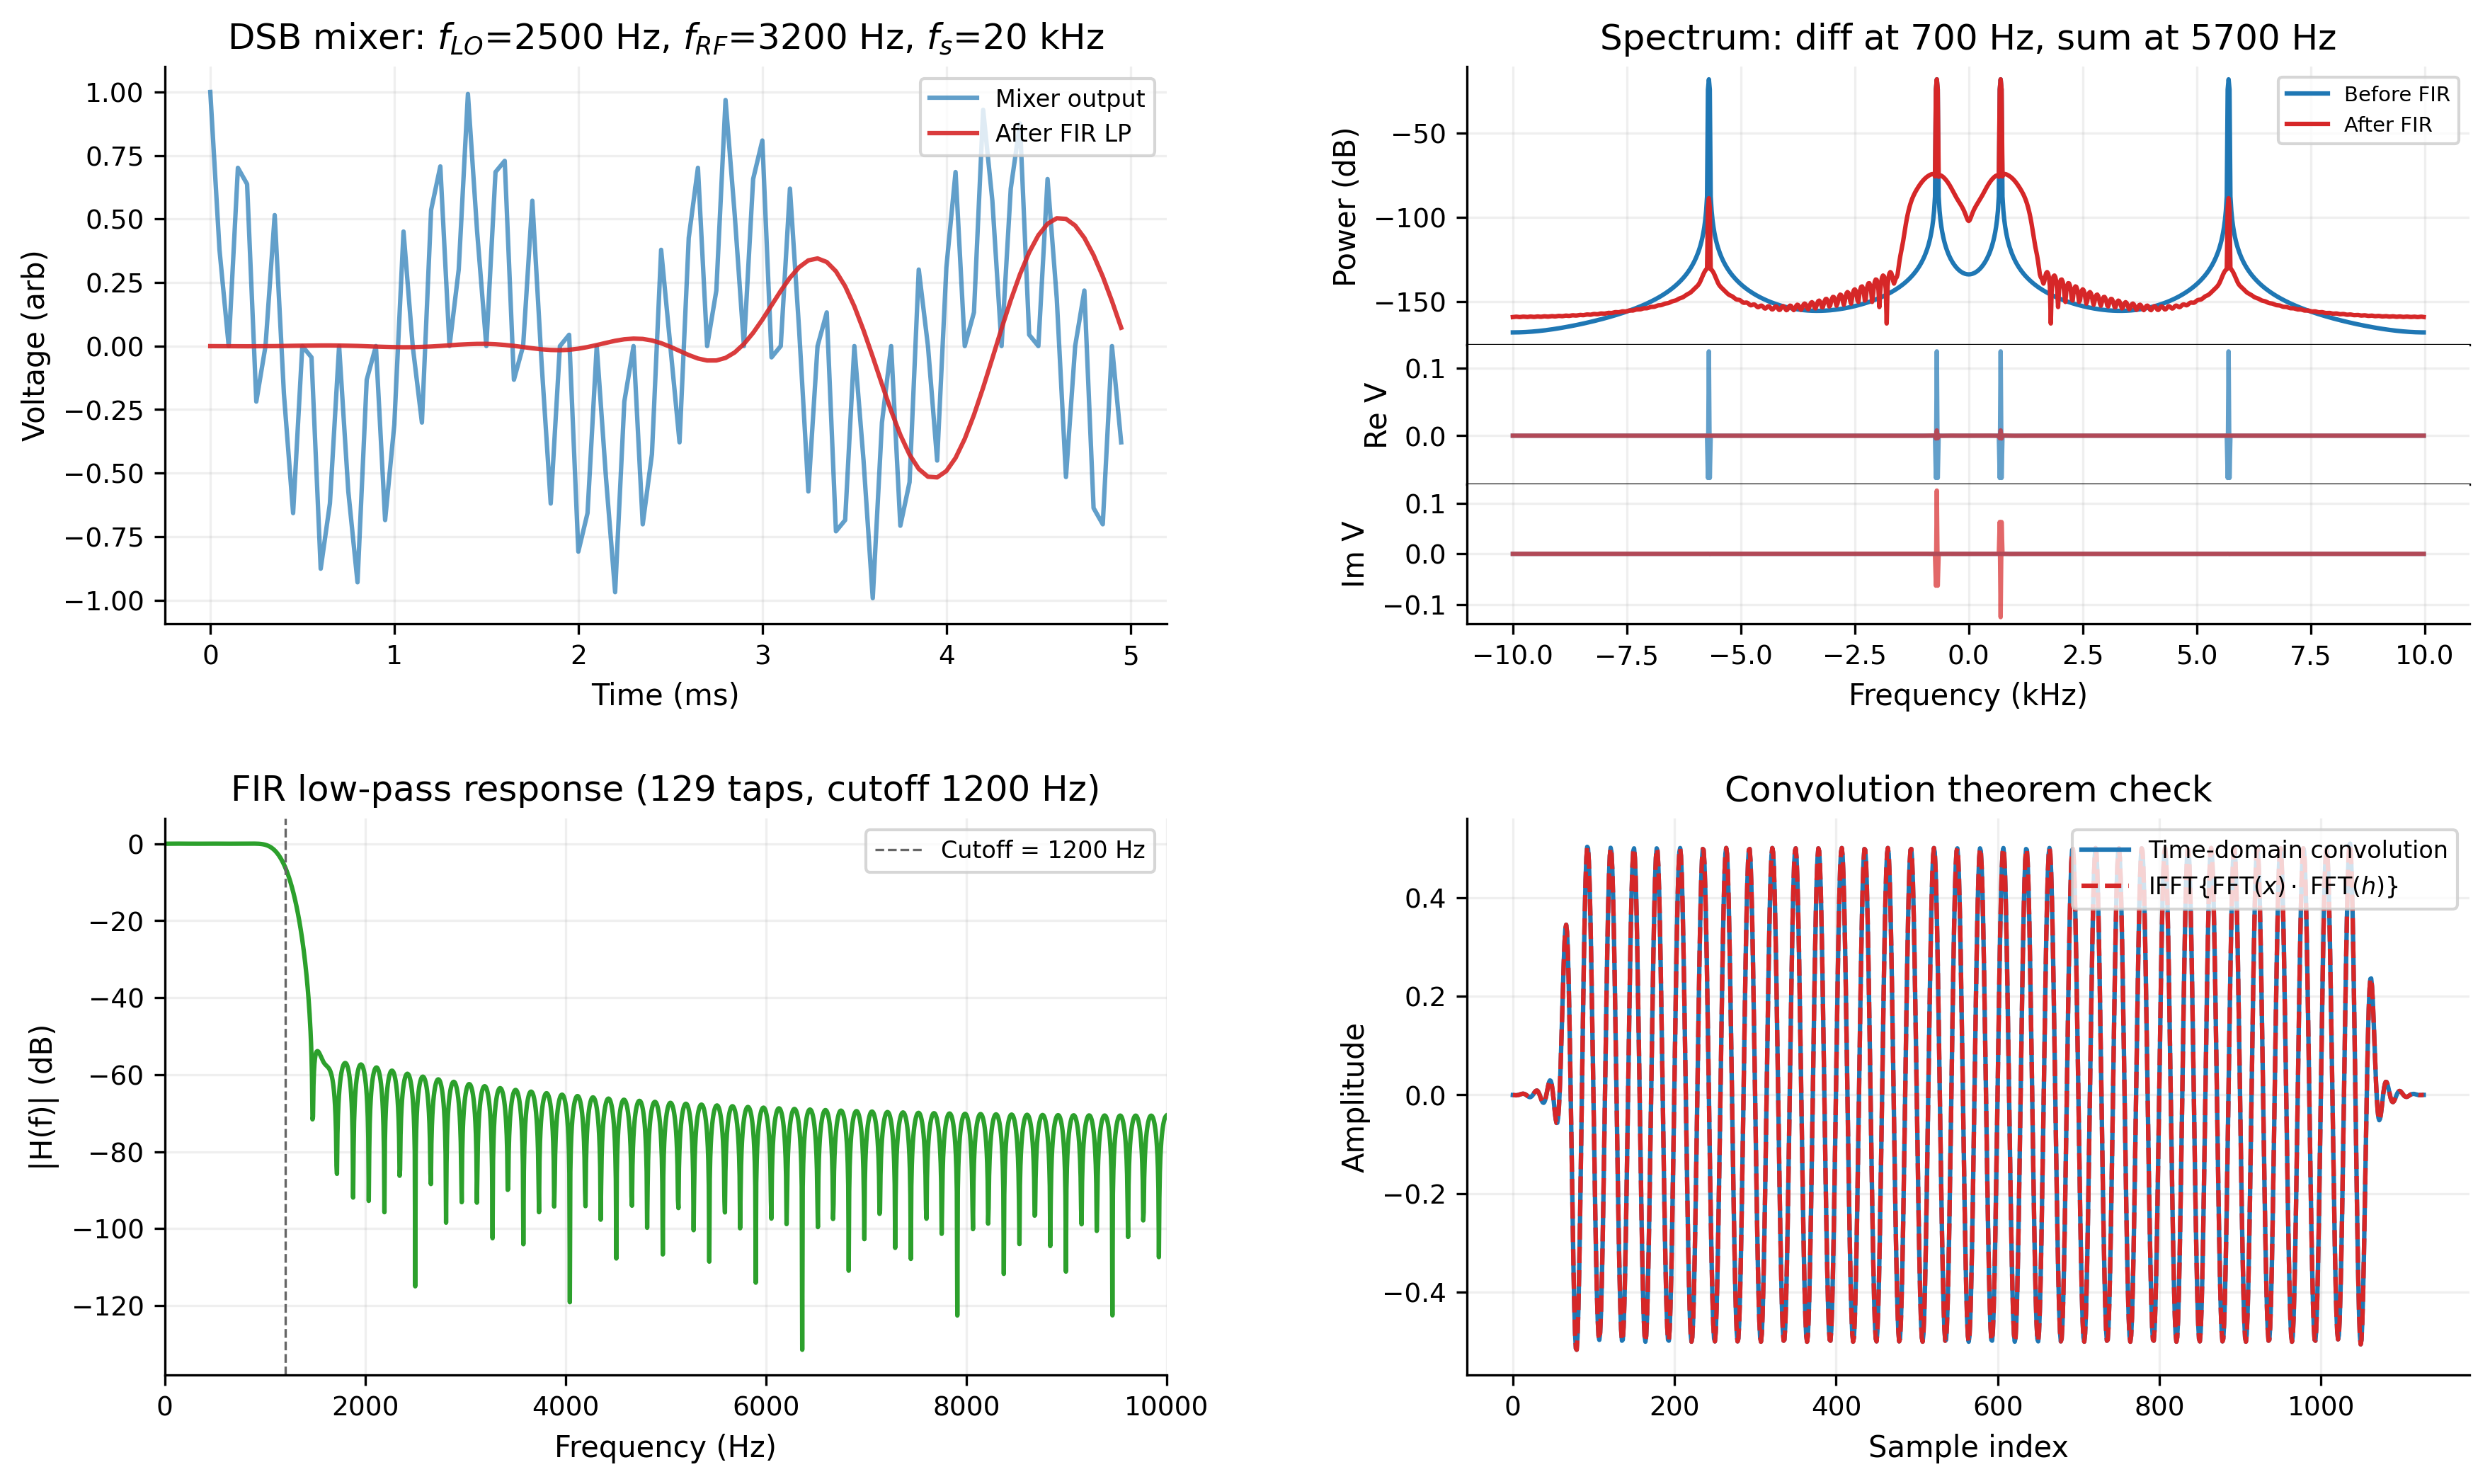

In [6]:
# THEORY_DEMO: Mixer products, FIR low-pass selection, and convolution theorem check
fs_hz = 20_000.0
duration_s = 0.05
t_s = np.arange(0.0, duration_s, 1.0 / fs_hz)

f_lo_hz = 2500.0
f_rf_hz = 3200.0
lo = np.cos(2.0 * np.pi * f_lo_hz * t_s)
rf = np.cos(2.0 * np.pi * f_rf_hz * t_s)
mixed = lo * rf

num_taps = 129
cutoff_hz = 1200.0
b = signal.firwin(num_taps, cutoff=cutoff_hz, fs=fs_hz)
filtered = signal.lfilter(b, [1.0], mixed)

conv_direct = np.convolve(mixed, b, mode="full")
n_fft = conv_direct.size
conv_freq = np.fft.ifft(np.fft.fft(mixed, n_fft) * np.fft.fft(b, n_fft)).real
conv_rel_err = np.linalg.norm(conv_direct - conv_freq) / max(np.linalg.norm(conv_direct), 1e-15)
print(f"Convolution theorem check (time-domain convolution must equal freq-domain multiplication):")
print(f"  Time-domain  ||conv(x, b)||   = {np.linalg.norm(conv_direct):.6e}")
print(f"  Freq-domain  ||IFFT(X·B)||    = {np.linalg.norm(conv_freq):.6e}")
print(f"  Relative error                = {conv_rel_err:.3e}")
print(f"  Match: {'PASS' if conv_rel_err < 1e-10 else 'FAIL'} (numerical threshold 1e-10)")

N_mix = len(mixed)
X_raw = np.fft.fftshift(np.fft.fft(mixed * np.hanning(N_mix))) / N_mix
X_filt = np.fft.fftshift(np.fft.fft(filtered * np.hanning(N_mix))) / N_mix
f_spec = np.fft.fftshift(np.fft.fftfreq(N_mix, d=1.0 / fs_hz))

P_raw = np.real(X_raw)**2 + np.imag(X_raw)**2
P_filt = np.real(X_filt)**2 + np.imag(X_filt)**2

w_hz, h = signal.freqz(b, worN=2048, fs=fs_hz)

fig, _ = plot_theory_mixer(
    t_s, mixed, filtered, f_spec, X_raw, X_filt, P_raw, P_filt, w_hz, h,
    conv_direct, conv_freq,
    f_lo_hz=f_lo_hz, f_rf_hz=f_rf_hz, fs_hz=fs_hz,
    cutoff_hz=cutoff_hz, num_taps=num_taps, conv_rel_err=conv_rel_err,
)
plt.show()

**Figure 4.** *(Top left)* Time-domain mixer output showing the product of a 2500 Hz LO and 3200 Hz RF tone sampled at 20 kHz. The raw mixer output (blue) contains both the 700 Hz difference-frequency beat and the 5700 Hz sum-frequency component; after a 129-tap FIR low-pass filter with 1200 Hz cutoff (orange), only the 700 Hz beat tone remains. *(Top right)* Power spectrum (dB) and voltage spectrum (real/imaginary) before and after FIR filtering. The pre-filter spectrum shows peaks at both $|f_{\text{RF}} - f_{\text{LO}}| = 700$ Hz and $f_{\text{RF}} + f_{\text{LO}} = 5700$ Hz; the post-filter spectrum retains only the difference product (passband), with the sum product signal (stopband) suppressed by ${\sim}60$ dB. Additionally, the voltage spectrum panels confirm that the filter preserves the phase structure of the passband signal while nulling the stopband signal. *(Bottom left)* FIR filter frequency response $|H(f)|$ in dB, showing the passband below 1200 Hz, a sharp transition band, and stopband attenuation exceeding 60 dB. *(Bottom right)* Convolution theorem consistency check: the time-domain convolution $x * b$ (solid) and the frequency-domain equivalent $\mathcal{F}^{-1}\{\hat{x}\cdot\hat{b}\}$ (dashed) overlay exactly, with a relative error at machine precision (${\sim}10^{-16}$), verifying the numerical equivalence of filtering in time and frequency domains.

*Note that the above FIR coefficient illustration is an exaggeration to illustrate the effects of FIR coefficients as a weighted convolution of a signal and its coupled use as a low-pass filter, the SDR we will be using only has 16 coefficients to set totalling a 32-tap symmetric FIR filter.*

## 3. Experimental Methods and Validation Protocol

### 3.1 Hardware

The primary receiver is an RTL-SDR dongle comprising an RTL2832U 8-bit ADC and an R820T silicon tuner, connected to a Raspberry Pi 4 running the `pyrtlsdr` driver. The SDR operates in direct-sampling mode for baseband experiments. Two signal generators provide sinusoidal test tones: a Rigol DS345 for frequencies below 50 MHz and a Agilent N9310A for higher-frequency LO/RF inputs. External DSB and SSB mixer hardware (Mini-Circuits ZAD-1) are used as well, with 50-ohm splitters, a 24-ft phase-delay cable, and an oscilloscope (Rigol DS1054Z) for signal monitoring.

### 3.2 Calibration and Pre-Checks

Every measurement session begins with a “mistrust everything” calibration protocol. The SDR is powered on for at least five minutes to stabilize thermal drift. Cable and connector continuity is verified end-to-end and minimized whereever possible.

Amplitude linearity is confirmed by stepping the signal generator output and verifying proportional ADC response below the clipping threshold. This is particularly important as due to the 8-bit nature of the ADC, there are limited ADC steps (256) to register a signal strength, as such, calibration runs are performed run to run and across sweeps to ensure readings, whereever possible, remain within the [-128, 127] range of the SDR. Figure 5 illustrates the time-domain diagnostics that distinguish a clean capture from a saturated one.

The first captured data block is discarded as a stale-buffer artifact, and a terminated-input noise-floor baseline is recorded for reference.


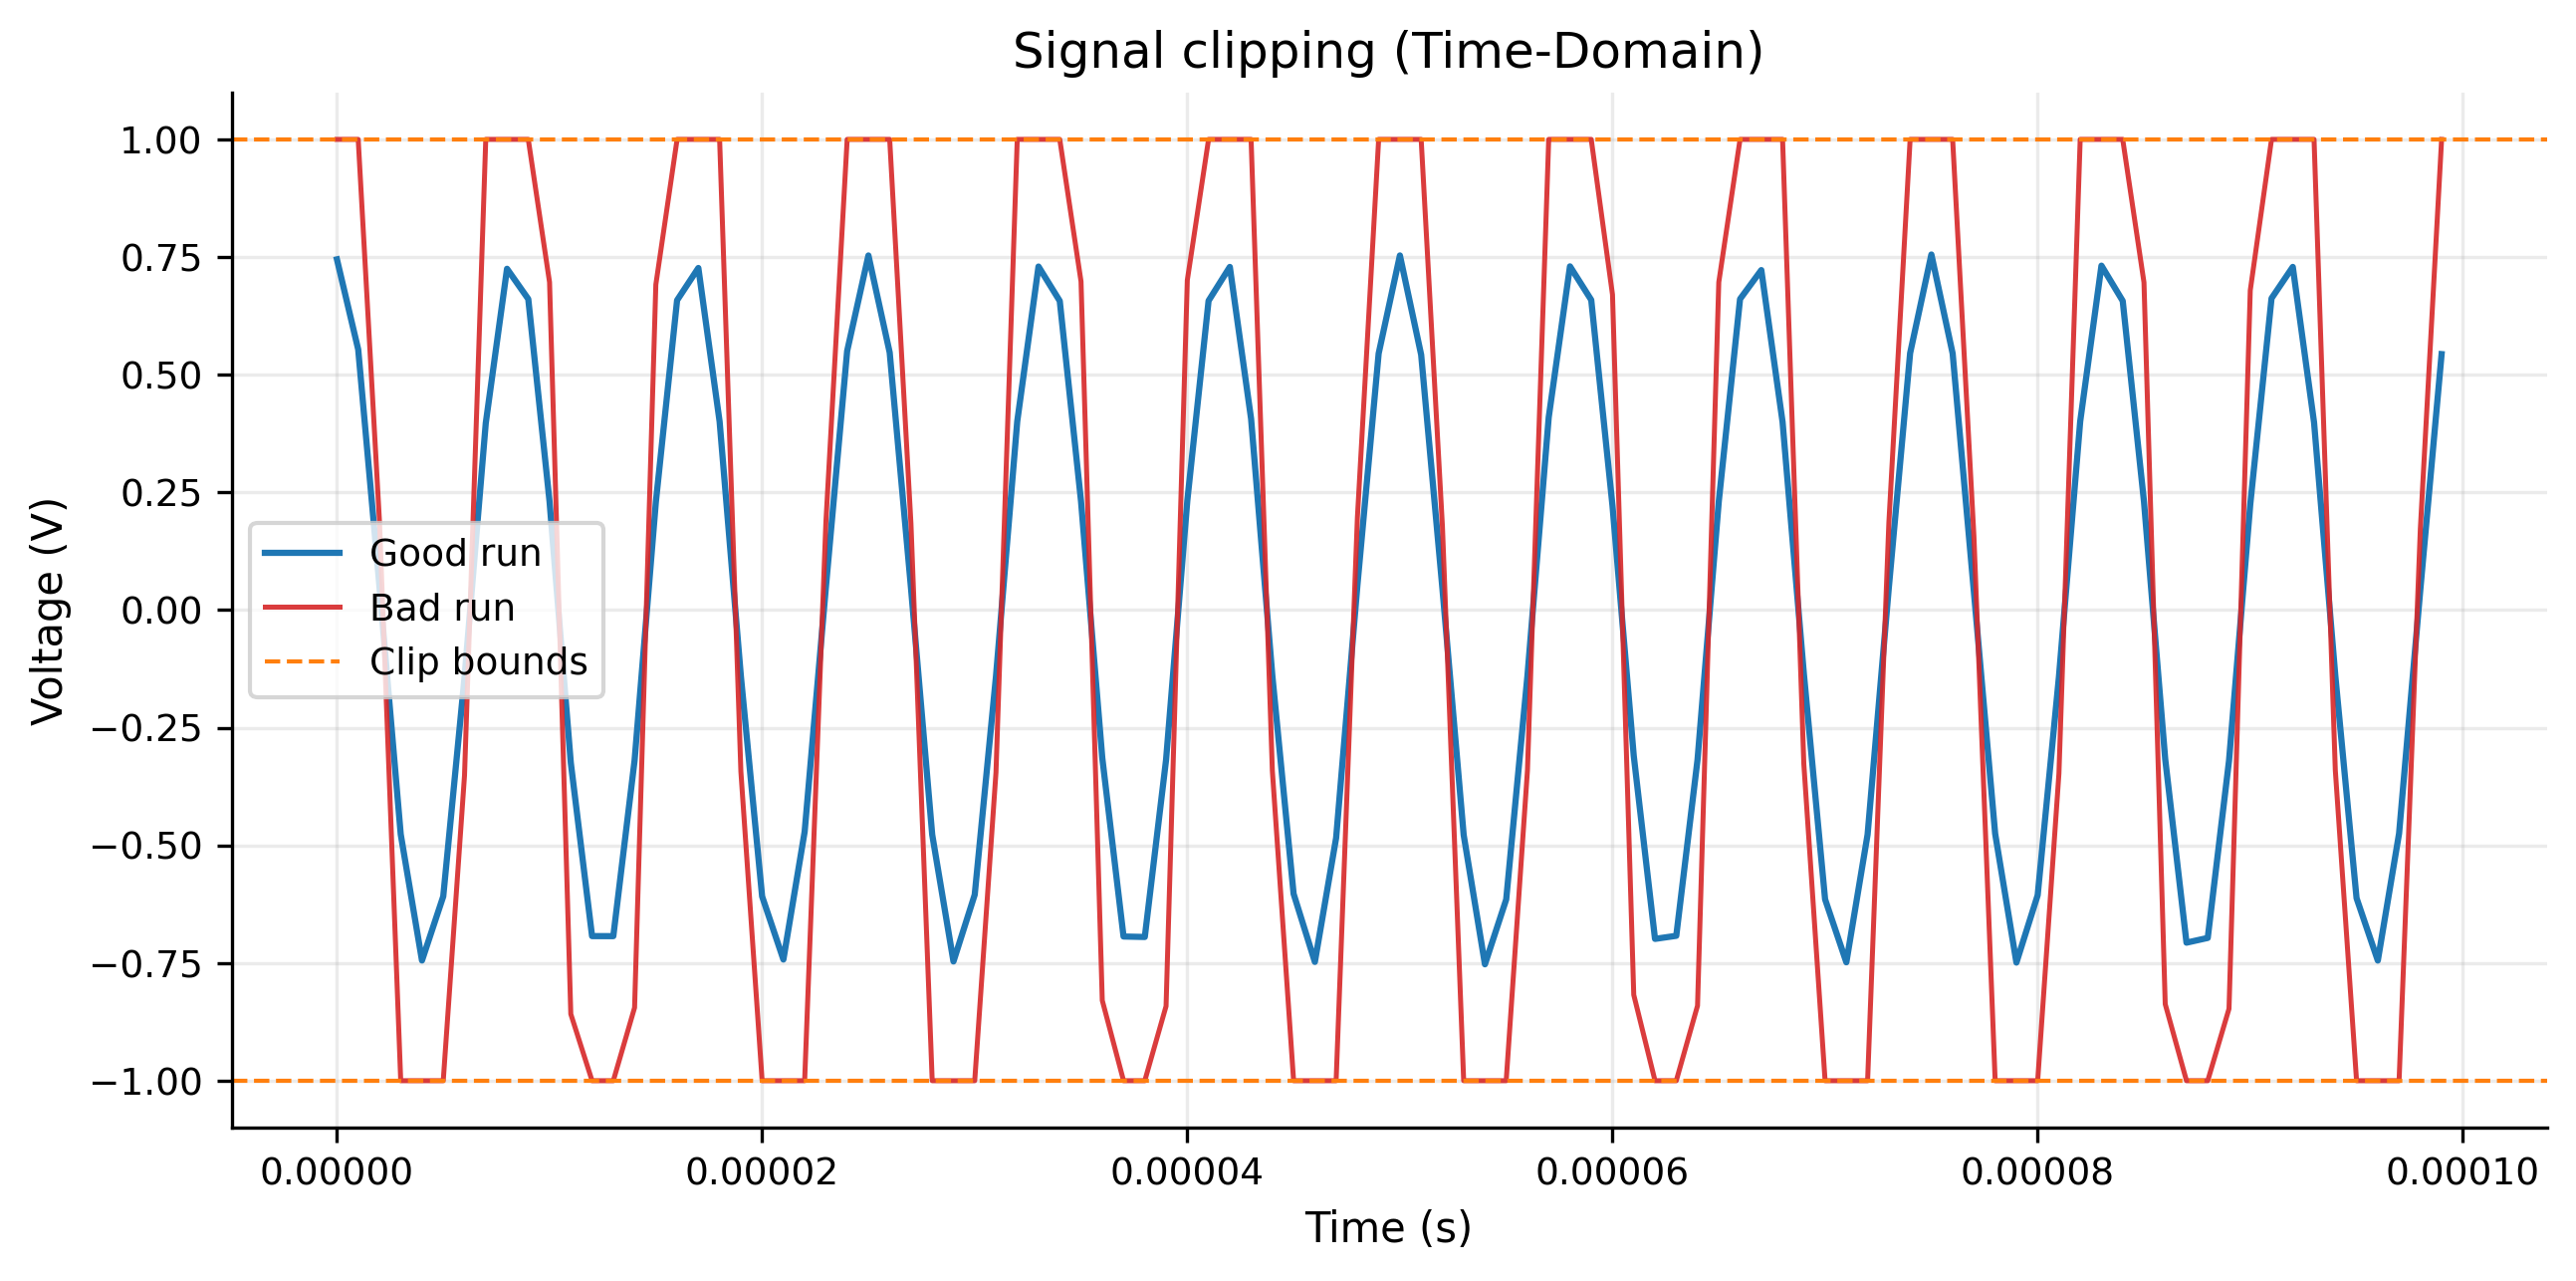

In [7]:
# SIM_RUNNER: Calibration/Pre-Checks -> F5
fs_precheck = 1.0e6
n_precheck = 2048

good_voltage = np.real(
    generate_multi_tone(
        frequencies_hz=np.array([120_000.0]),
        sample_rate_hz=fs_precheck,
        n_samples=n_precheck,
        amplitudes_v=np.array([0.75]),
        phases_rad=np.array([0.0]),
        complex_output=True,
        noise_std_v=0.005,
        rng=RNG,
    )
)
time_s_precheck = sample_times(good_voltage.size, fs_precheck)

bad_voltage = np.clip(2.8 * good_voltage + 0.05, -1.0, 1.0)

fig_f3, _ = plot_calibration_precheck(
    time_s_precheck,
    good_voltage,
    bad_voltage,
    clip_limits_v=(-1.0, 1.0),
)


**Figure 5 Signal clipping.** A good run is a clean sinusoidal capture with stable amplitude and no distortion. A bad run however is clipped/saturated capture where the ADC rails are hit, producing flat-topped waveforms and harmonic artifacts. These time-domain checks for clipping are performed before every experiment to ensure data quality.

### 3.3 Data Collection Drivers

Hardware control and acquisition are handled through two dedicated drivers: `labs/01/src/ugradio_lab1/control/siggen.py` and `labs/01/src/ugradio_lab1/control/sdr.py`. The signal-generator interface (`siggen.py`) wraps the Agilent N9310A over USBTMC (`/dev/usbtmc0`) and issues SCPI commands to set CW frequency/power (`set_freq_mhz`, `set_ampl_dbm`) and RF state (`rf_on`, `rf_off`). All reads/writes run under a retry policy with timeout, polling, and settle delays, so transient I/O failures are retried before the run is marked failed.

The SDR interface (`sdr.py`) is a capture wrapper around `ugradio.sdr` (resolved through `_resolve_sdr_factory`) and defines `SDRCaptureConfig` for run settings. Data are acquired through `acquire_sdr_capture` with per-capture timeout and retry handling. Captures are requested in direct-sampling mode for this lab, optional FIR coefficients can be injected (including the alias-hack profile), and the first block is discarded via `stale_blocks` to remove startup-buffer artifacts. The returned `SDRCaptureResult` includes de-staled blocks, requested versus actual sample rate, and ADC guard metrics (`mean_block_rms`, clipping bounds, pass/fail) used by QC.

### 3.4 Data Pipeline

The development of this pipeline is assisted by Claude code for efficient data product handling, though I've noticed that this resulted in a heavily over-engineered package. Briefly, raw captures are stored as compressed archives (`data/raw/eX.tar.gz`) containing NumPy arrays with per-run metadata (sample rate, tone frequencies, power level, FIR mode, cable configuration). The `ugradio_lab1` Python package processes these through a three-stage pipeline: raw ingestion with QC flagging, interim tables with derived metrics, and processed report-ready tables and figures.

## 4. Experiments

For this lab, I have organized the characterization of digital sampling, and etc. behaviour into a series of experiments. Each experiment have the following structure: a guiding research question, a concise theory motivation, a materials-and-methods description, simulation checks where applicable, and physical results from SDR measurements.

### 4.1 Nyquist Sampling and Aliasing

**Does the measured alias frequency match the Nyquist folding prediction to within one DFT frequency bin?**

The sampling theorem predicts that a tone at frequency $f$ sampled at rate $f_s$ aliases to
$f_{\text{alias}} = \left|((f + f_s/2) \bmod f_s) - f_s/2\right|$ in $[0, f_s/2]$.
Deviations from this prediction would indicate non-ideal sampling behavior in the SDR hardware.

#### Materials and Methods

The RTL-SDR operates in direct-sampling mode at four sample rates (1.0, 1.6, 2.4, 3.2 MHz).
A Rigol DG1022Z signal generator sweeps a constant-amplitude tone from 0 to $4 f_{\text{Nyquist}}$
in 24 steps per rate, producing 545 total captures stored in `data/raw/e1.tar.gz`.
Both default FIR and alias-hack modes are tested at multiple power tiers. See §3 for the full calibration protocol.

#### Experimental Results

Agreement is strongest inside the Nyquist window: for $f_{\text{true}} \le f_s/2$, the measured dominant-bin frequencies follow the Nyquist-aliasing prediction closely, typically within one DFT bin ($\Delta f = f_s/N$).
For injected tones above Nyquist, the inferred folded frequency is much less well resolved, with larger scatter.

A likely cause is reduced signal amplitude before digitization. The E2 bandpass characterization (Figure 7) shows strong attenuation outside the effective passband (with substantial rolloff beyond the passband edge).
Those out-of-window tones therefore produce significantly lower ADC RMS counts, so their folded spectra are lower-SNR and the power-spectrum peak is broadened/noise-limited.
As such, although the aliasing trend is vaguely observable, the measured alias frequency is poorly resolved when attenuation pushes the signal near the noise floor.

E1 T3: 545 alias measurements


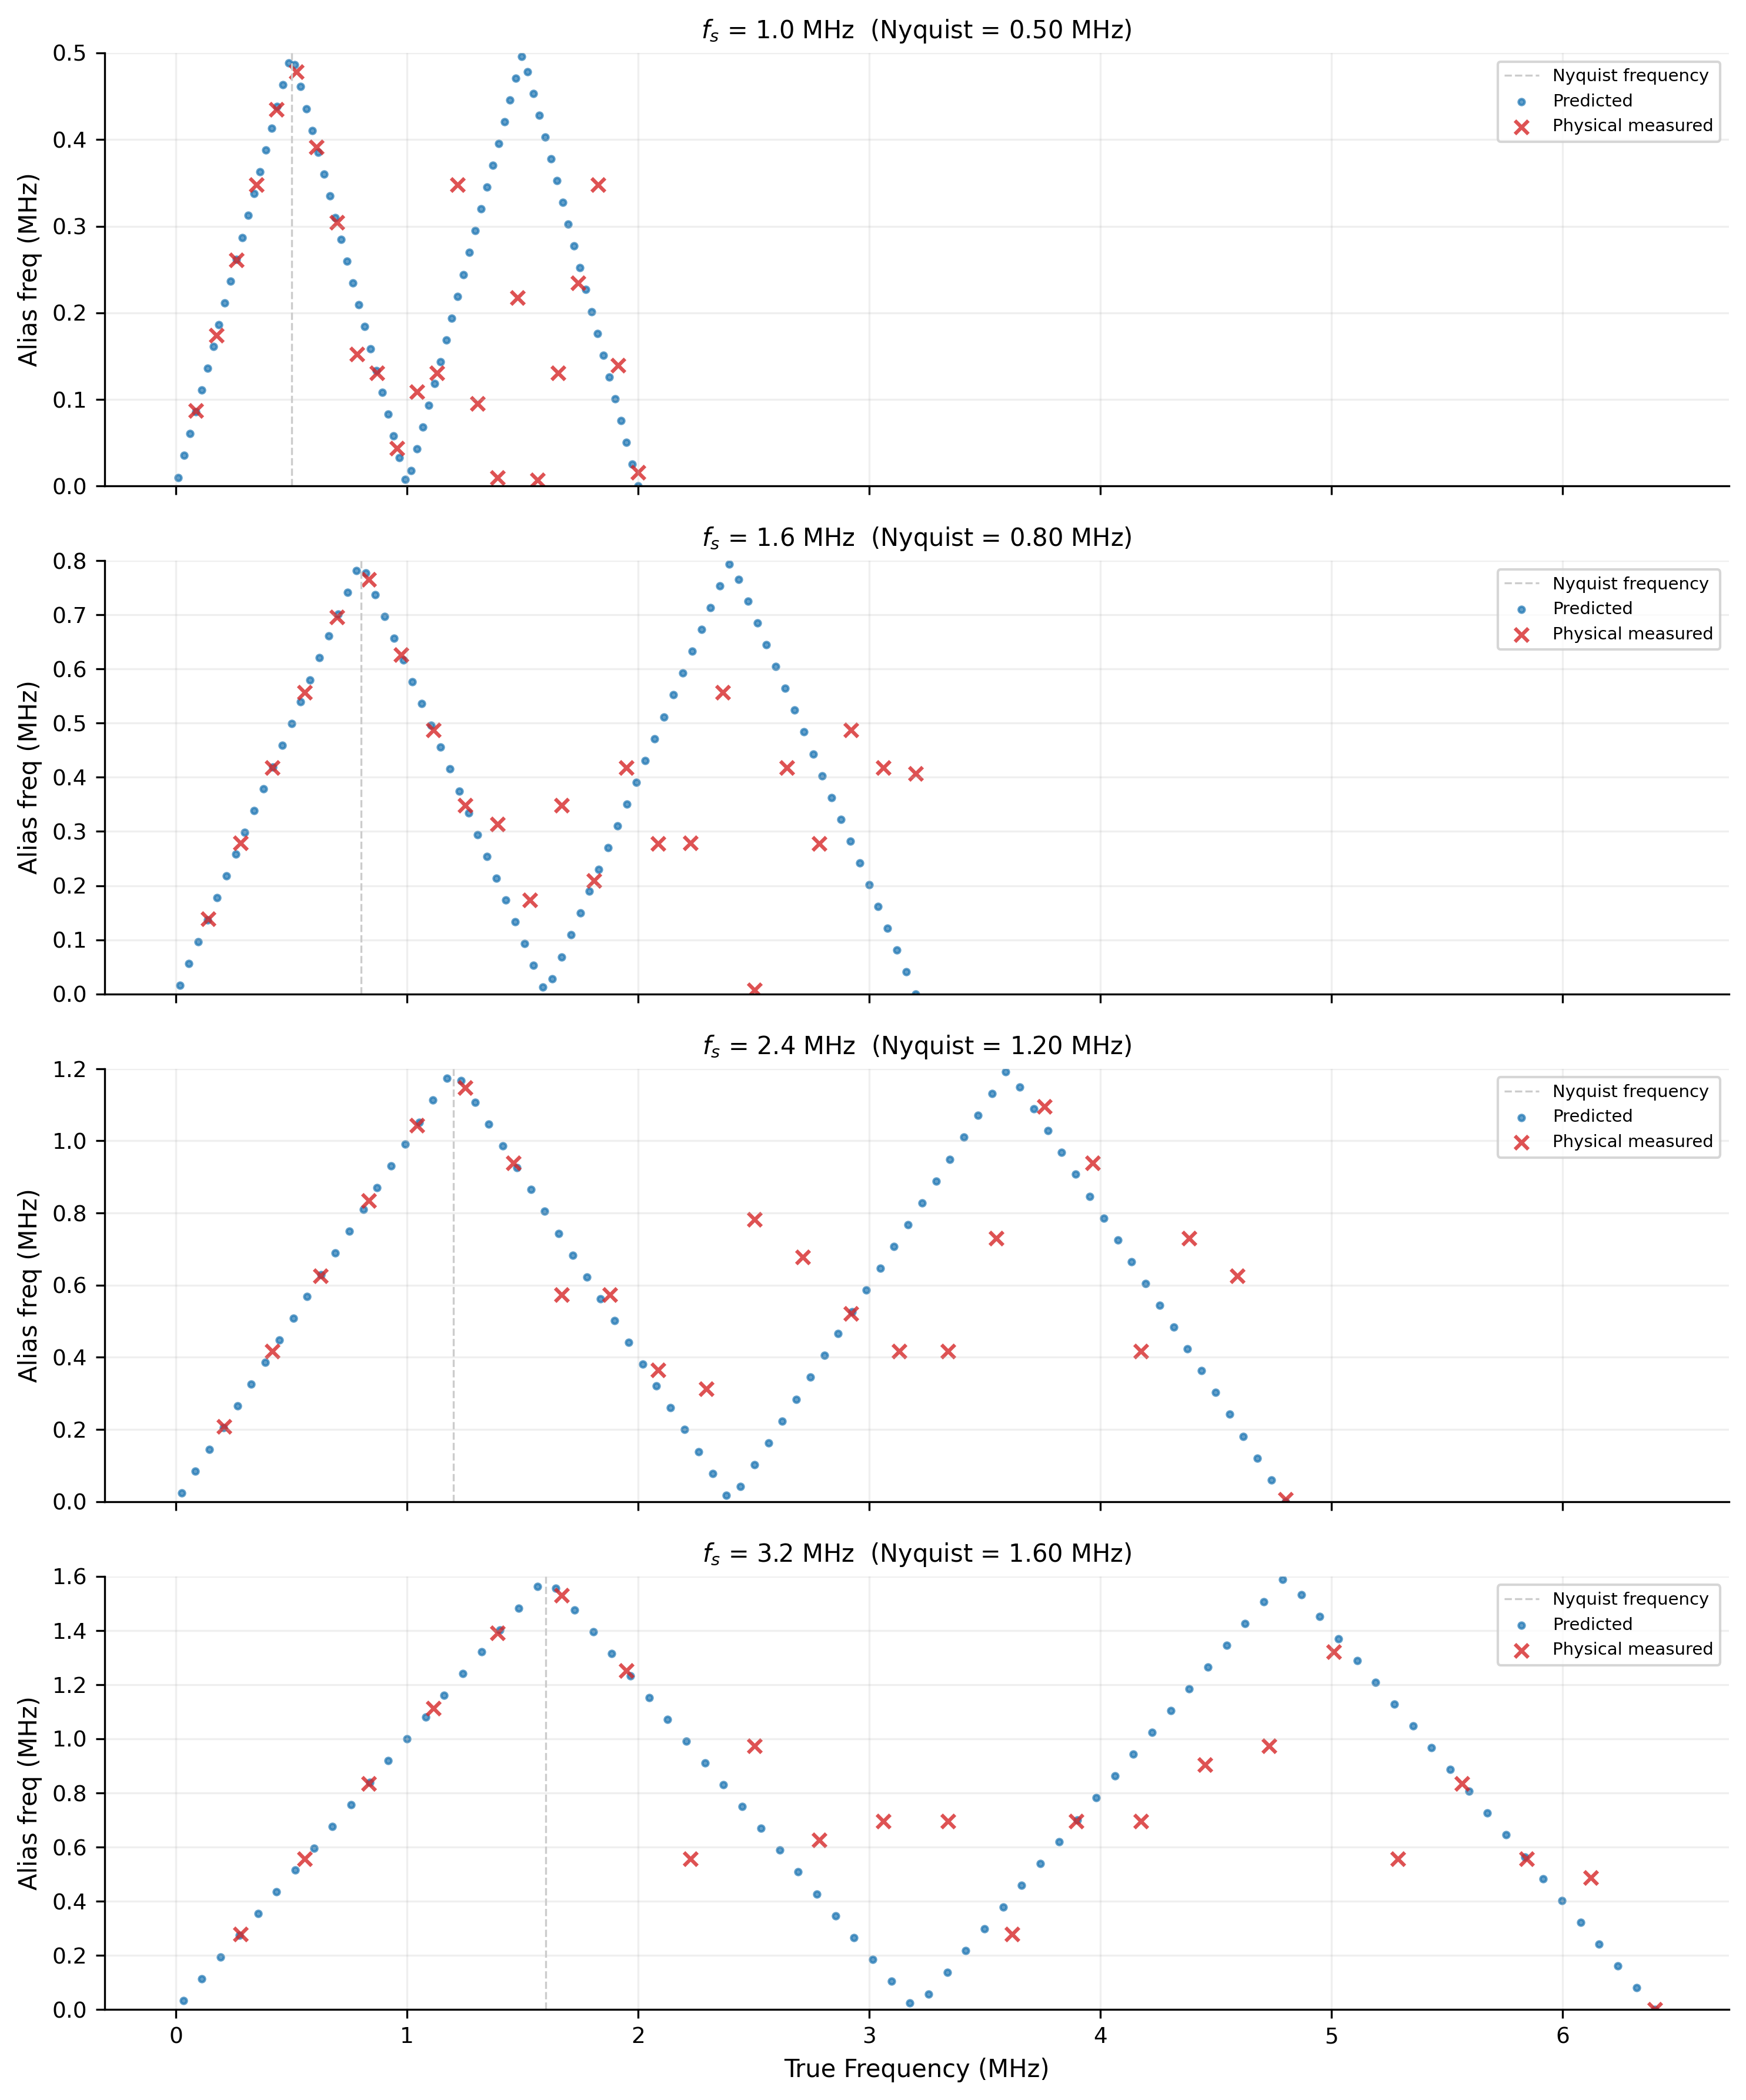

In [8]:
# E1 PHYSICAL: Nyquist aliasing — measure peak frequency from each run
fs_values = np.array([1.0e6, 1.6e6, 2.4e6, 3.2e6], dtype=float)
n_samples_e1 = 2048

f_true_grid: list[float] = []
fs_grid: list[float] = []
for fs in fs_values:
    nyq = fs / 2.0
    fractions = np.linspace(0.02, 4.0, 80)
    f_points = fractions * nyq
    f_true_grid.extend(f_points.tolist())
    fs_grid.extend([float(fs)] * f_points.size)

alias_sim = simulate_alias_sweep(
    np.array(f_true_grid),
    np.array(fs_grid),
    n_samples=n_samples_e1,
    amplitude_v=1.0,
    noise_std_v=0.01,
    complex_output=True,
    rng=RNG,
)
alias_table = alias_sim.table.sort_values(
    ["sample_rate_hz", "f_true_hz"], kind="stable"
).reset_index(drop=True)

e1_runs = qc.loc[
    (qc["experiment"] == "E1") & (qc["qc_analysis_pass"] == True)
].copy()

e1_t3_rows = []
for _, row in e1_runs.iterrows():
    arrays = load_arrays_for_catalog_row(row)
    blocks = np.asarray(arrays["adc_counts"], dtype=np.int8).astype(float)
    fs_hz = float(row["sample_rate_hz_actual"])
    f_true = float(row["signal_frequency_hz"])

    freq_hz, power_v2 = power_spectrum(
        blocks.reshape(-1), sample_rate_hz=fs_hz,
        window=None, detrend=True, scaling="power", center=True,
    )
    peak_idx = np.argmax(power_v2)
    measured_alias_hz = abs(float(freq_hz[peak_idx]))

    e1_t3_rows.append({
        "run_id": str(row["run_id"]),
        "f_true_hz": f_true,
        "sample_rate_hz": fs_hz,
        "predicted_alias_hz": abs(float(predict_alias_frequency(f_true, fs_hz))),
        "measured_alias_hz": measured_alias_hz,
    })

e1_t3_physical = pd.DataFrame(e1_t3_rows)
print(f"E1 T3: {e1_t3_physical.shape[0]} alias measurements")

fig_f2, _ = plot_e1_alias_map_combined(alias_table, e1_t3_physical, fs_values)

**Figure 6: Alias frequency map (simulation and experimental).** Each panel corresponds to one sample rate (1.0, 1.6, 2.4, 3.2 MHz). Predicted alias frequencies (circles) follow the Nyquist-aliasing pattern reported as unsigned alias magnitude in $[0, f_s/2]$. Nyquist frequency $f_s/2$ is denoted as a vertical dashed line. Experimental hardware measurements (X markers) agree very well with theory inside the Nyquist window, with residual spread near the bin width $\Delta f = f_s/N$. For tones injected outside Nyquist, the folded peak is more poorly resolved and can deviate from the expected alias bin, consistent with E2-measured bandpass attenuation that lowers ADC RMS counts and degrades power-spectrum peak localization.

### 4.2 SDR Bandpass Characterization

**What is the effective passband shape of the RTL-SDR at each sample rate?**

The RTL2832U with a R820T tuner induces a frequency-dependent gain on the baseband signal.
Characterizing this bandpass is useful for interpreting amplitude measurements in subsequent experiments.

#### Materials and Methods

A constant-amplitude tone from the Agilent N9310A is swept programmatically across the SDR baseband range at each of the
four sample rates (1.0, 1.6, 2.4, 3.2 MHz), recording peak spectral power versus offset frequency.
The pipeline processes 234 raw captures from `data/raw/e2.tar.gz`. See §3 for hardware details.

#### Experimental Results

The gain-vs-frequency curves below show the measured passband in both the native frequency axis and
folded modulo $f_s/2$ to reveal the effective gain experienced by aliased signals.

E2 bandpass: 4 modes, 234 points


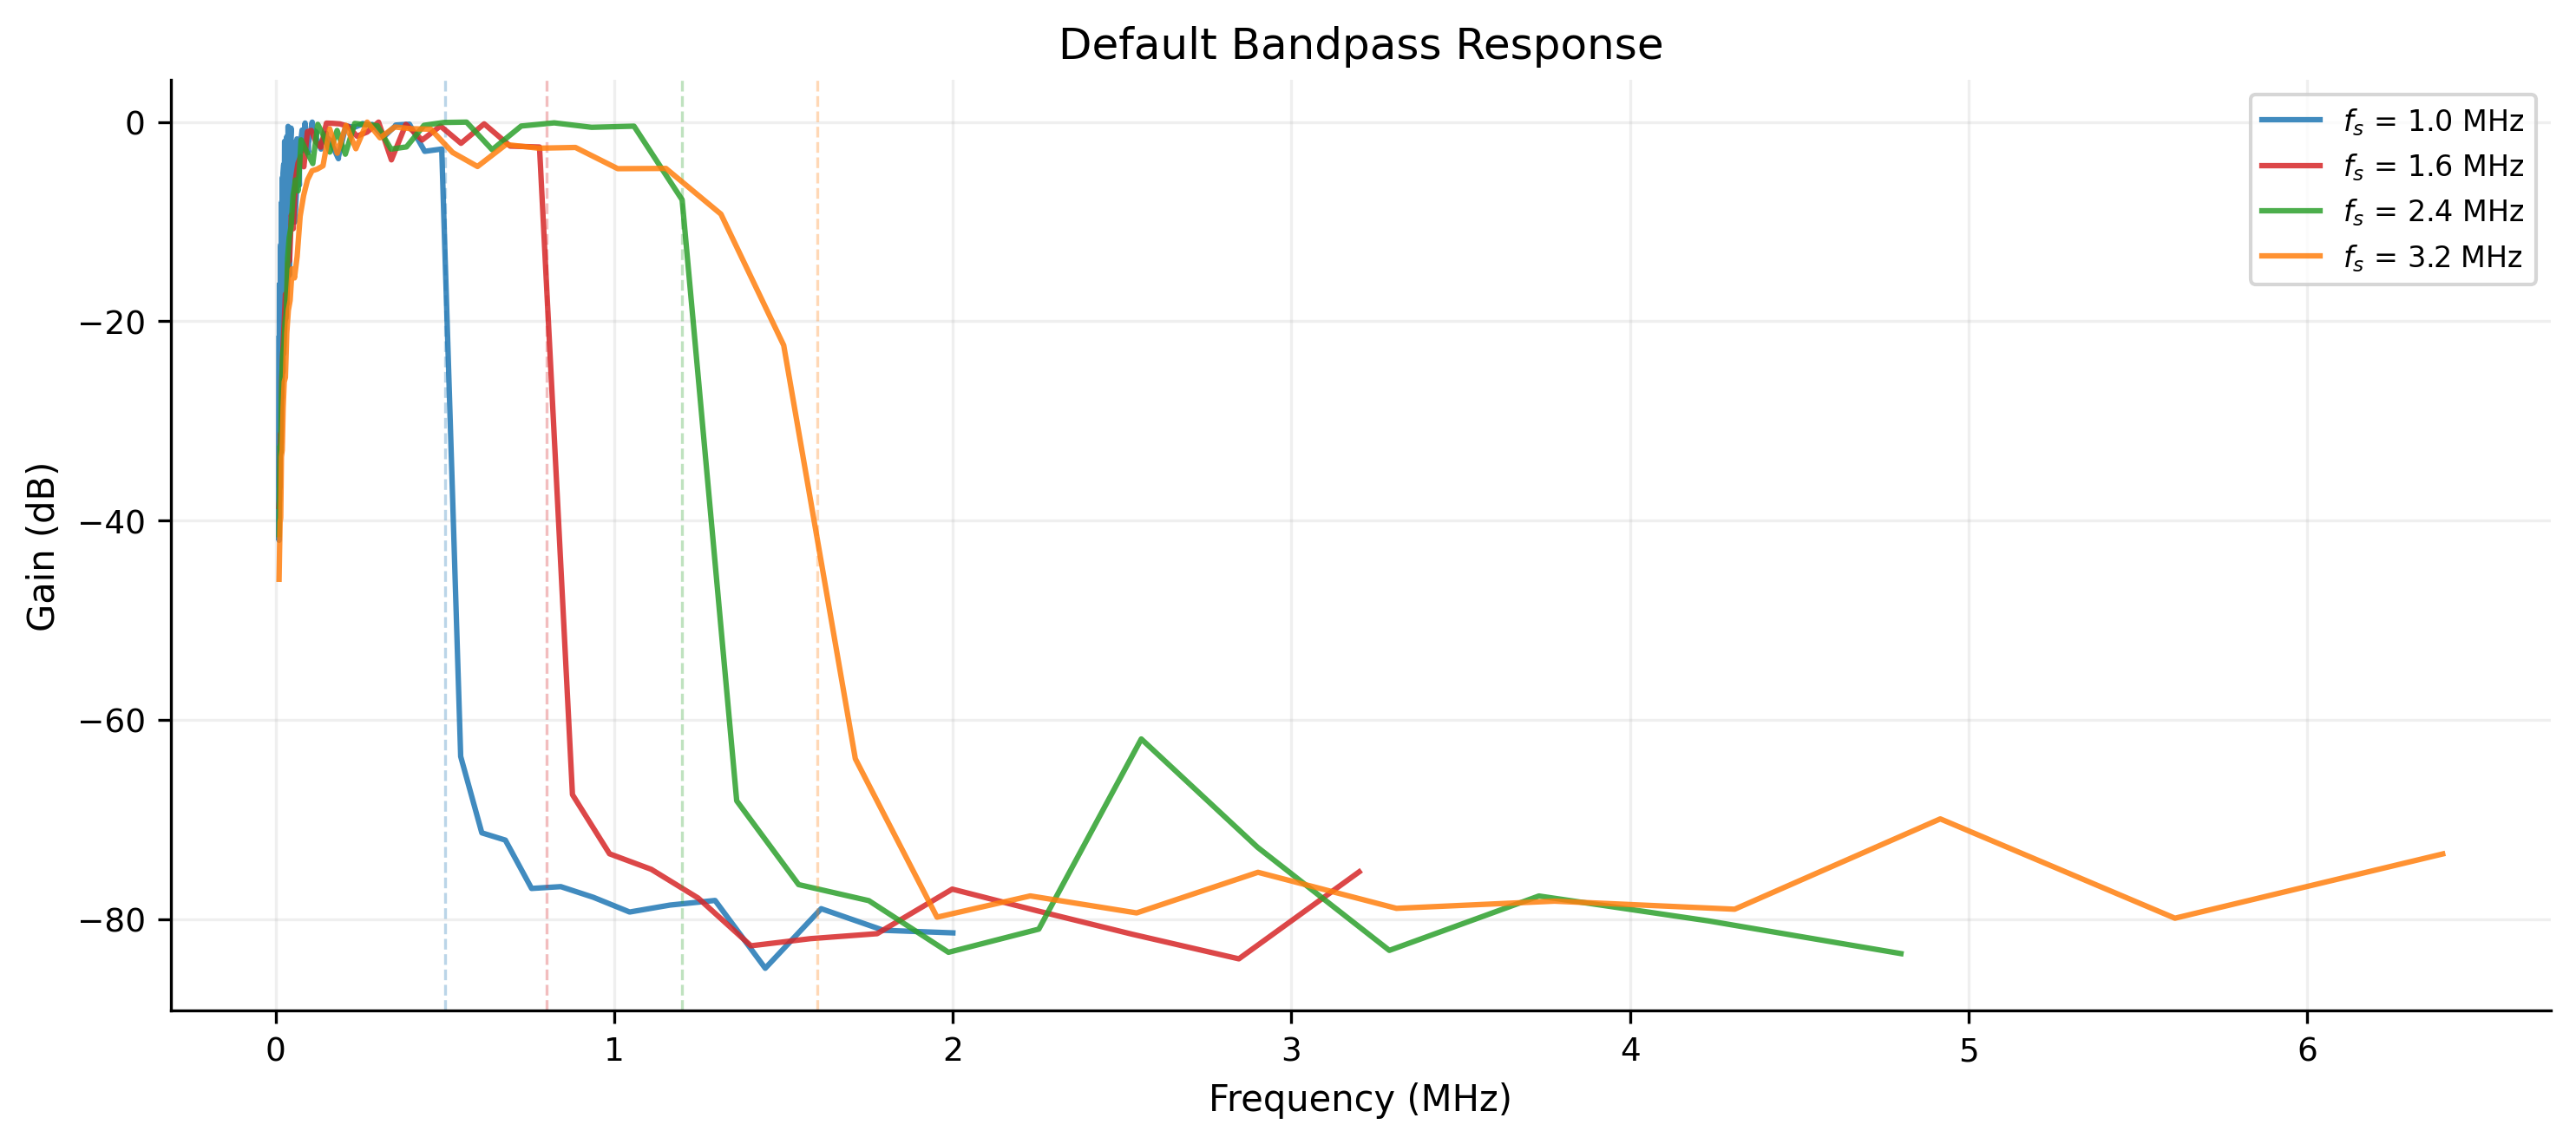

In [9]:
# E2 PHYSICAL: SDR bandpass characterization
e2_runs = qc.loc[
    (qc["experiment"] == "E2") & (qc["qc_analysis_pass"] == True)
].copy()

curve_rows = []
for _, row in e2_runs.iterrows():
    arrays = load_arrays_for_catalog_row(row)
    blocks = np.asarray(arrays["adc_counts"], dtype=np.int8).astype(float)
    fs_hz = float(row["sample_rate_hz_actual"])
    f_signal = float(row["signal_frequency_hz"])
    fir_mode = str(row.get("fir_mode", "default"))

    # Average power spectrum, then extract amplitude at signal frequency
    avg = average_power_spectrum(
        blocks, sample_rate_hz=fs_hz,
        window=None, detrend=True, scaling="power", center=True,
    )
    freq_hz = avg.frequency_hz
    power_v2 = avg.mean
    nearest_idx = int(np.argmin(np.abs(freq_hz - f_signal)))
    amplitude_v = float(np.sqrt(np.maximum(power_v2[nearest_idx], 0.0)))

    mode_label = f"{fir_mode}@{fs_hz/1e6:.1f}MHz"
    curve_rows.append({
        "run_id": str(row["run_id"]),
        "mode": mode_label,
        "frequency_hz": f_signal,
        "amplitude_v": amplitude_v,
        "sample_rate_hz_nominal": fs_hz,
        "fir_mode": fir_mode,
    })

e2_curve_raw = pd.DataFrame(curve_rows)

e2_curve_parts = []
for mode_label, group in e2_curve_raw.groupby("mode", sort=True):
    group = group.sort_values("frequency_hz")
    bc = bandpass_curve(
        group["frequency_hz"].to_numpy(dtype=float),
        group["amplitude_v"].to_numpy(dtype=float),
        mode=str(mode_label),
    )
    bc["sample_rate_hz_nominal"] = group["sample_rate_hz_nominal"].iloc[0]
    e2_curve_parts.append(bc)

e2_curve_table = pd.concat(e2_curve_parts, ignore_index=True)
print(f"E2 bandpass: {len(e2_curve_table['mode'].unique())} modes, {e2_curve_table.shape[0]} points")

fig_f4, _ = plot_e2_bandpass_default_and_aliased(e2_curve_table)

**Figure 7: SDR bandpass response.** The default-mode (`default=None`) gain-vs-frequency curves for four sample rates (1.0, 1.6, 2.4, 3.2 MHz), measured by sweeping a constant-amplitude tone across the SDR baseband. Dashed vertical lines mark each Nyquist frequency $f_s/2$. Passband widths range from ~412 kHz (1.0 MHz) to ~983 kHz (3.2 MHz), and the default FIR filter shows substantial out-of-band rejection (>20 dB rolloff beyond the passband edge).

### 4.3 Voltage and Power Spectra

**Do the real and imaginary components of the voltage spectrum preserve phase information that the power spectrum discards. Does Parseval's theorem hold?**

The complex voltage spectrum $\hat{v}[k]$ retains both amplitude and phase, while the power spectrum
$P[k] = |\hat{v}[k]|^2$ is non-negative and phase-blind.
With the normalization used by `voltage_spectrum(..., scaling="amplitude")`,
$\hat{v}[k] = \mathrm{FFT}\{v[n]\}/N$, so Parseval becomes
$$
\langle |v|^2 \rangle
= \frac{1}{N}\sum_{n=0}^{N-1}|v[n]|^2
= \sum_{k=0}^{N-1} P[k].
$$

For real-valued time-domain voltages, the DFT must satisfy Hermitian symmetry:
$$
\hat{v}[-k] = \hat{v}[k]^*.
$$
This implies three testable symmetry relations:
$$
\Re\{\hat{v}[-k]\}=\Re\{\hat{v}[k]\} \quad (\text{even}),
\qquad
\Im\{\hat{v}[-k]\}=-\Im\{\hat{v}[k]\} \quad (\text{odd}),
\qquad
P[-k]=P[k].
$$

Rather than asserting these qualitatively, we compute relative residuals in both simulation and physical data:
$\epsilon_P$ (Parseval), $\epsilon_H$ (Hermitian), $\epsilon_{\Re,\text{even}}$,
$\epsilon_{\Im,\text{odd}}$, and an evenness residual for $P[k]$.

#### Materials and Methods

A synthetic two-tone complex signal validates normalization and demonstrates phase-sensitive asymmetry.
Four physical SDR captures (three single-tone, one two-tone) acquired in direct-sampling mode at
3.2 MHz are processed from `data/raw/e3.tar.gz`. See §3 for acquisition protocol.

#### Simulation


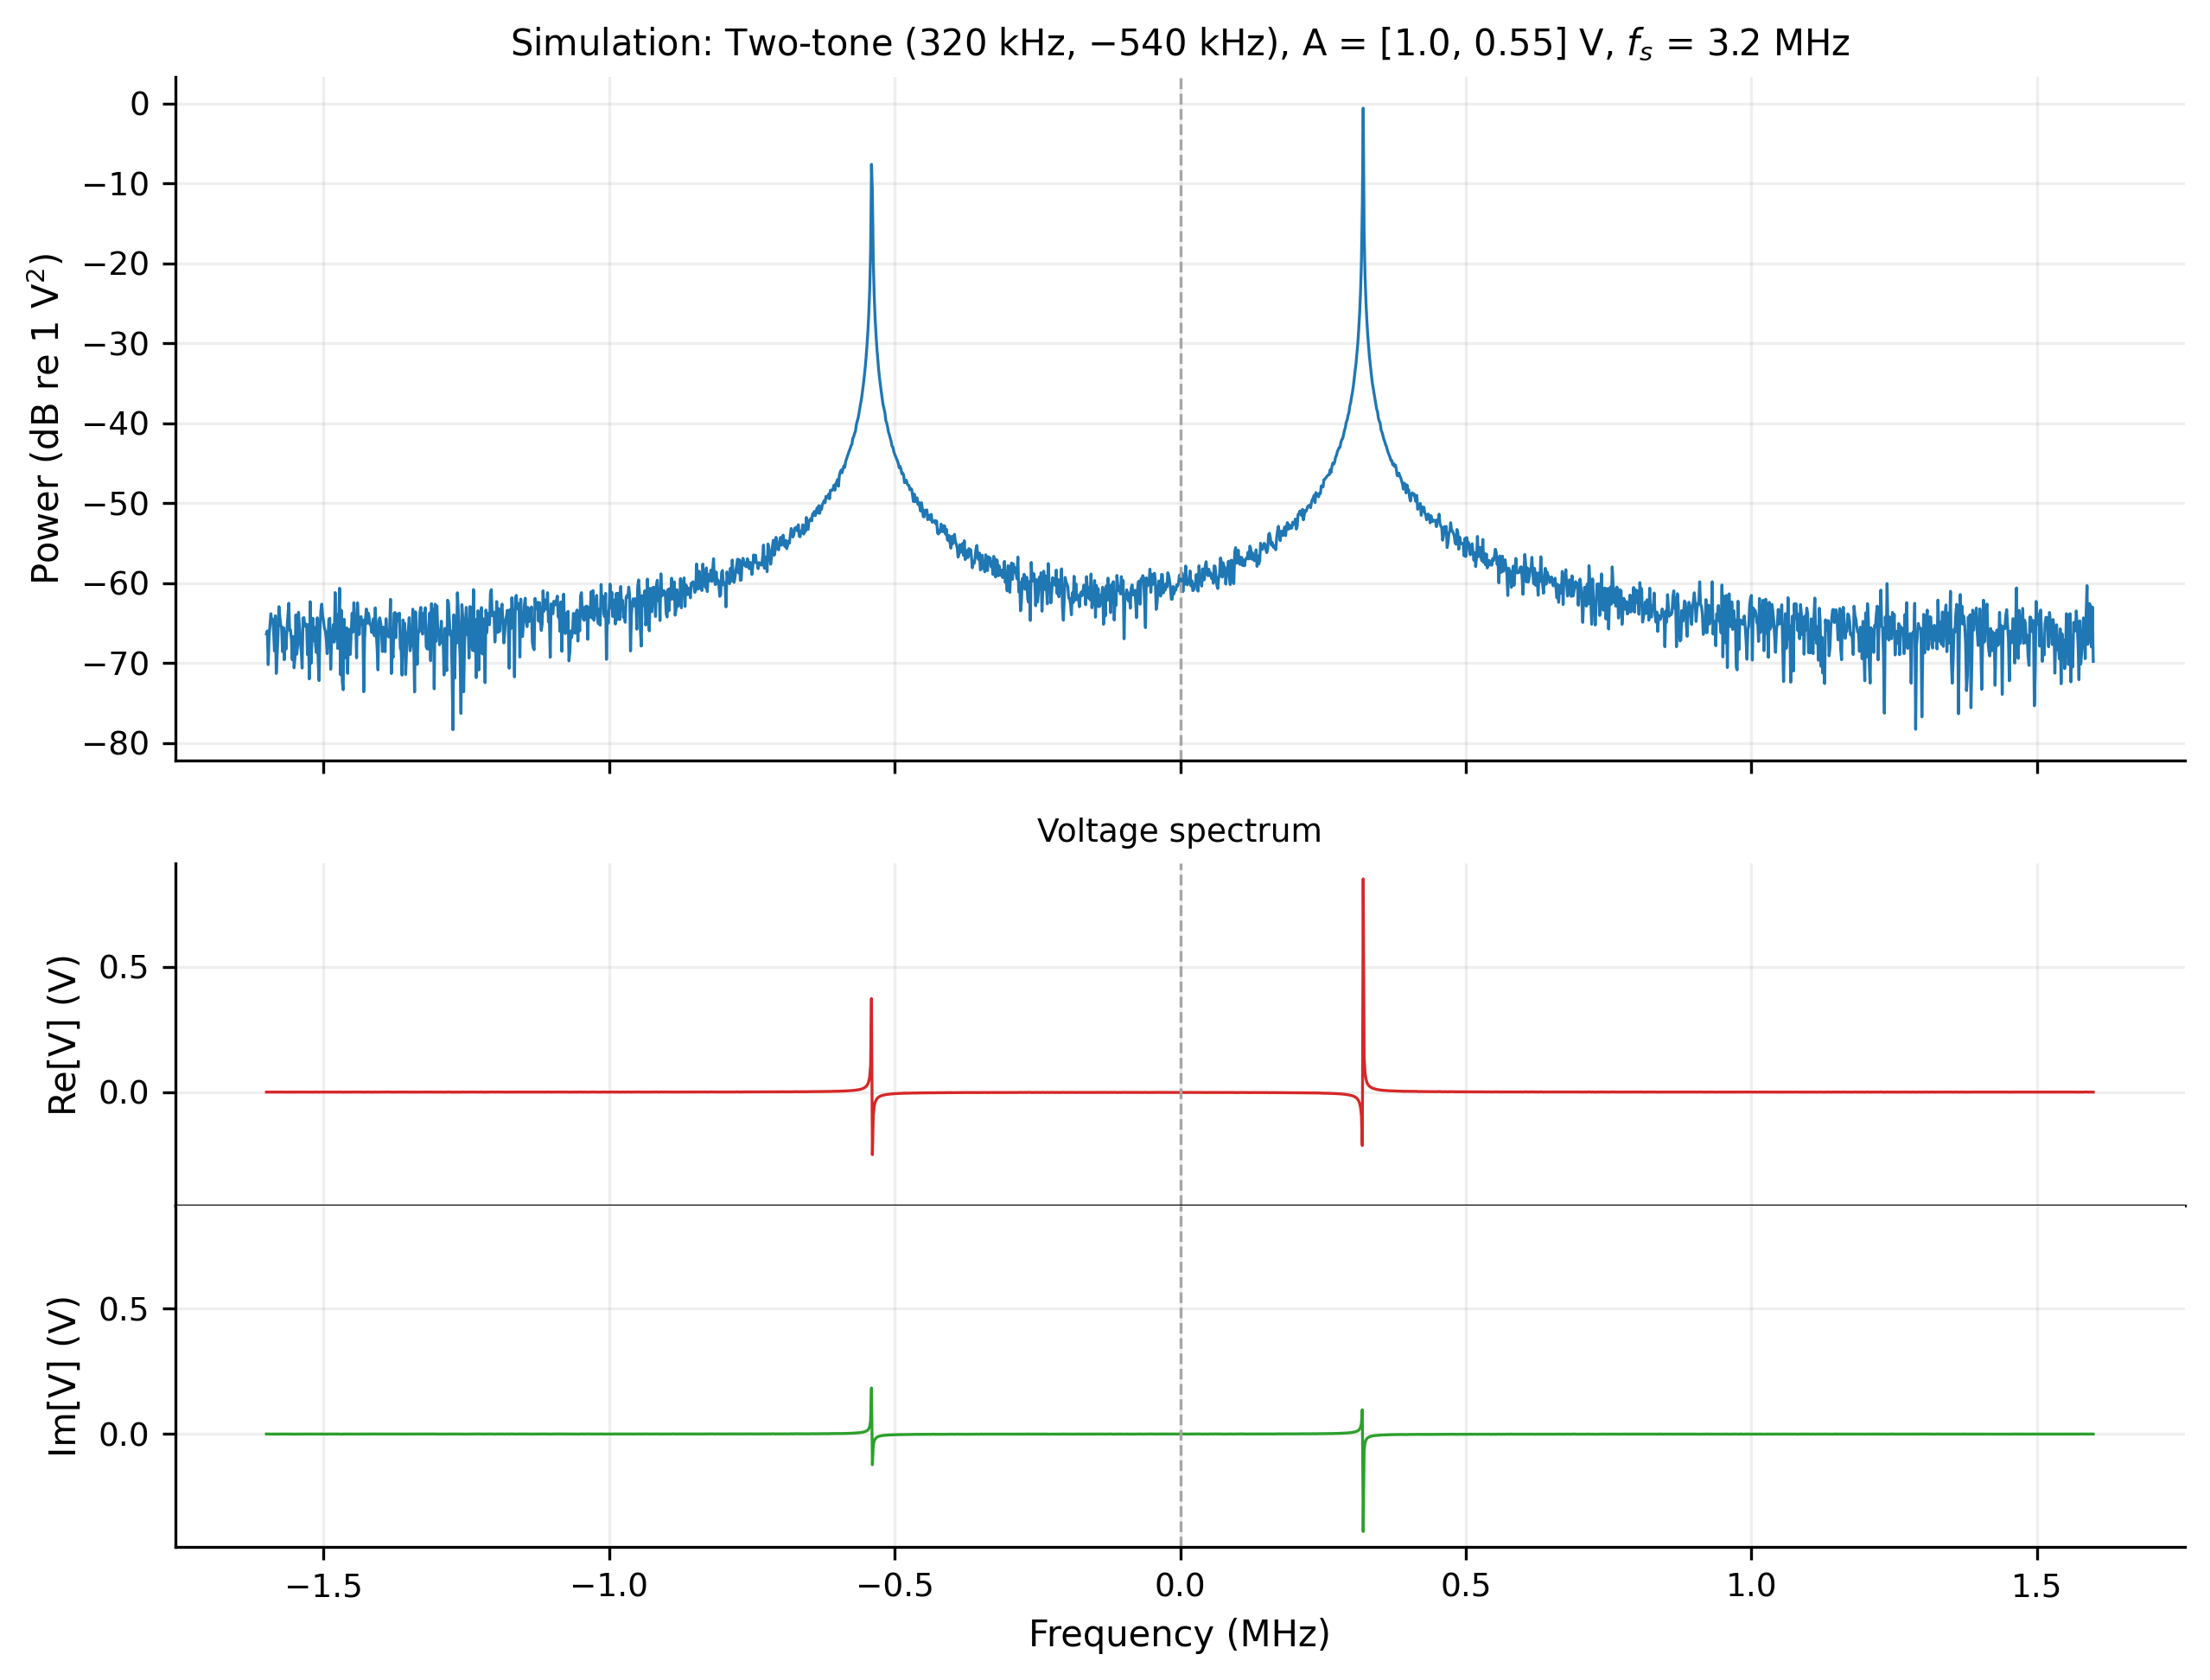

In [10]:
# SIM_RUNNER: E3 Voltage/Power spectra -> F5
fs_e3 = 3.2e6
n_e3 = 2048

voltage_e3 = generate_multi_tone(
    frequencies_hz=np.array([320_000.0, -540_000.0]),
    sample_rate_hz=fs_e3,
    n_samples=n_e3,
    amplitudes_v=np.array([1.0, 0.55]),
    phases_rad=np.array([0.2, -0.8]),
    complex_output=True,
    noise_std_v=0.01,
    rng=RNG,
)

freq_hz, spec_v = voltage_spectrum(
    voltage_e3,
    sample_rate_hz=fs_e3,
    center=True,
    scaling="amplitude",
)
_, power_v2 = power_spectrum(
    voltage_e3,
    sample_rate_hz=fs_e3,
    center=True,
    scaling="power",
)


fig_f5, _ = plot_e3_stacked_spectrum_sim(
    freq_hz,
    spec_v,
    power_v2,
    title="Simulation: Two-tone (320 kHz, −540 kHz), A = [1.0, 0.55] V, $f_s$ = 3.2 MHz",
)
plt.show()

**Figure 8: Stacked voltage and power spectra for a synthetic two-tone signal.** A complex-valued signal with tones at +320 kHz (amplitude 1.0 V) and −540 kHz (amplitude 0.55 V) is sampled at $f_s = 3.2$ MHz with $N = 2048$. The power spectrum (top, dB scale) shows two clean peaks at the injected frequencies with the expected ~5.2 dB amplitude difference. The real (middle) and imaginary (bottom) voltage spectra preserve the full complex phase structure.

#### Experimental Results

Four SDR captures are processed: three single-tone runs at different power levels and one two-tone run.
Each column below shows a top-row power spectrum and stacked voltage subplots (Re above Im), matching the theory Fourier layout.

E3 spectrum profile: 4 runs, 8192 rows


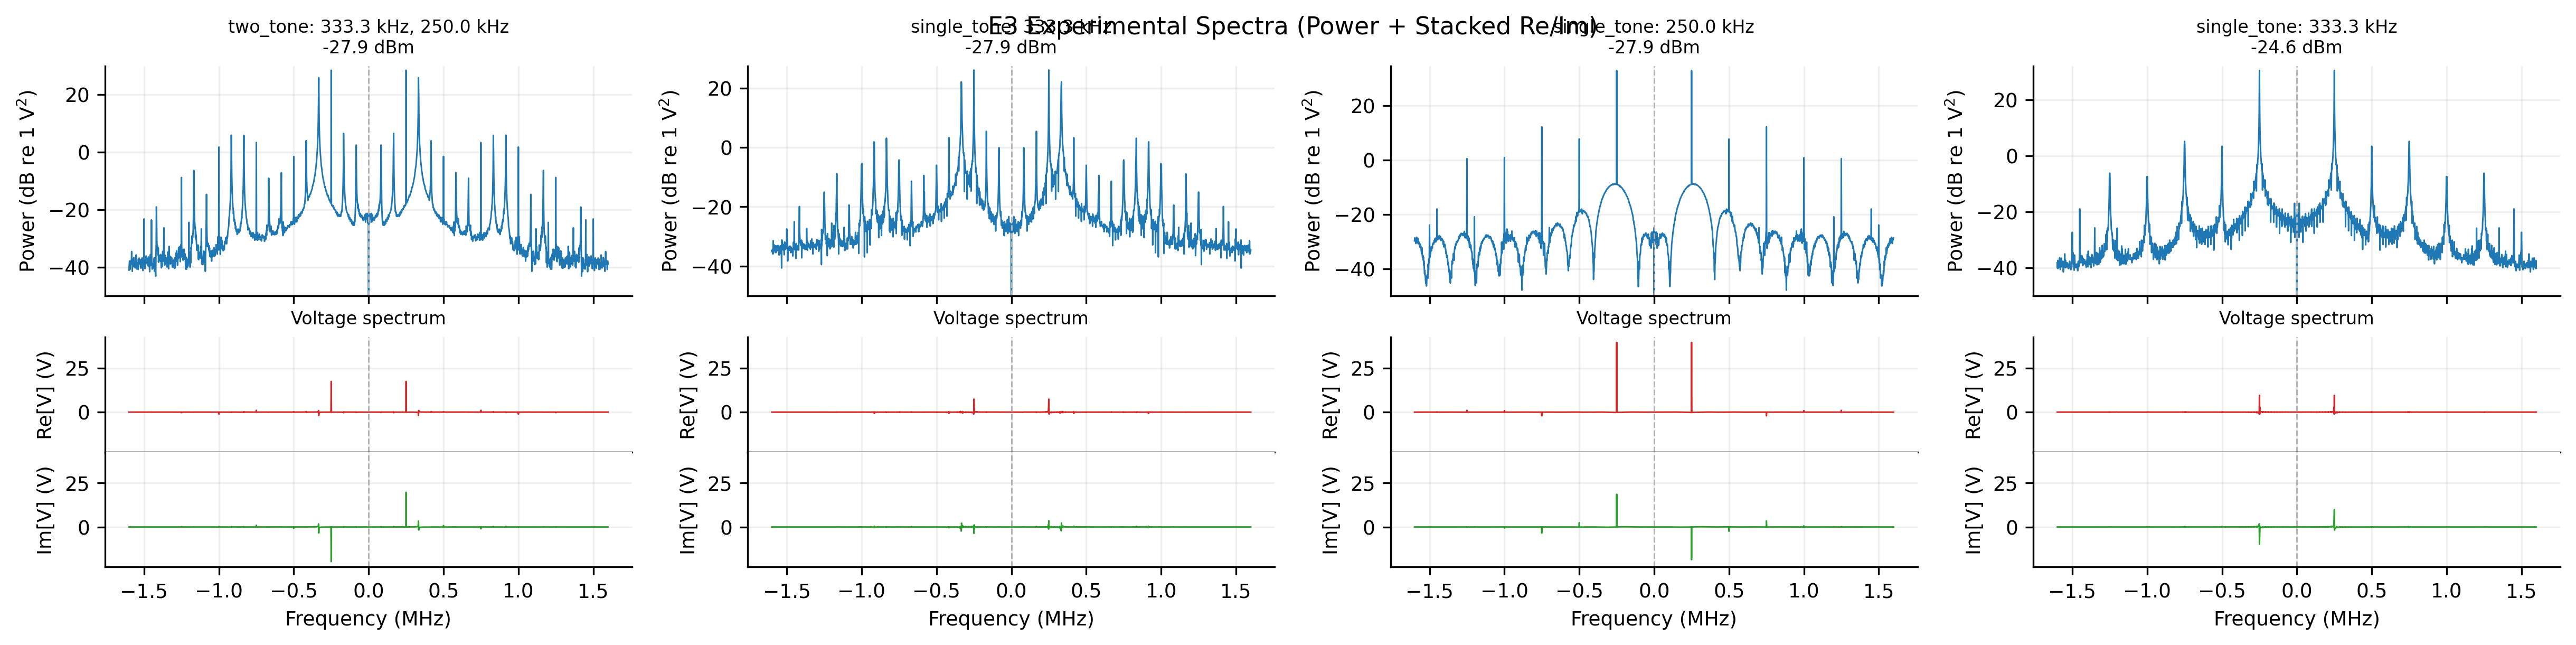

In [11]:
# E3 PHYSICAL: Voltage and power spectra from SDR captures
e3_runs = qc.loc[
    (qc["experiment"] == "E3") & (qc["qc_analysis_pass"] == True)
].copy()
e3_runs = e3_runs.sort_values("run_id", kind="stable").reset_index(drop=True)


def _e3_symmetry_metrics(spec_v: np.ndarray) -> dict[str, float]:
    spectrum = np.fft.ifftshift(np.asarray(spec_v, dtype=np.complex128))
    partner = spectrum[(-np.arange(spectrum.size)) % spectrum.size]
    scale = np.sqrt(np.mean(np.abs(spectrum) ** 2)) + 1e-30

    return {
        "hermitian_rel_resid": float(
            np.sqrt(np.mean(np.abs(partner - np.conj(spectrum)) ** 2)) / scale
        ),
        "re_even_rel_resid": float(
            np.sqrt(np.mean((np.real(partner) - np.real(spectrum)) ** 2)) / scale
        ),
        "im_odd_rel_resid": float(
            np.sqrt(np.mean((np.imag(partner) + np.imag(spectrum)) ** 2)) / scale
        ),
    }


def _e3_power_even_residual(power_v2: np.ndarray) -> float:
    arr = np.fft.ifftshift(np.asarray(power_v2, dtype=float))
    partner = arr[(-np.arange(arr.size)) % arr.size]
    scale = np.sqrt(np.mean(arr ** 2)) + 1e-30
    return float(np.sqrt(np.mean((partner - arr) ** 2)) / scale)


profile_parts = []
e3_diag_rows = []
for _, row in e3_runs.iterrows():
    arrays = load_arrays_for_catalog_row(row)
    blocks = np.asarray(arrays["adc_counts"], dtype=np.int8).astype(float)
    fs_hz = float(row["sample_rate_hz_actual"])
    run_id = str(row["run_id"])

    # Block-averaged voltage spectrum and time-domain mean power
    spectrum_blocks = []
    block_time_mean_v2 = []
    freq_hz = None
    for block in blocks:
        block_detrended = block - np.mean(block)
        block_time_mean_v2.append(float(np.mean(np.abs(block_detrended) ** 2)))

        f, s = voltage_spectrum(
            block,
            sample_rate_hz=fs_hz,
            window=None,
            detrend=True,
            scaling="amplitude",
            center=True,
        )
        if freq_hz is None:
            freq_hz = f
        spectrum_blocks.append(np.asarray(s, dtype=np.complex128))

    stacked = np.vstack(spectrum_blocks)
    spec_mean = np.mean(stacked, axis=0)

    # Block-averaged power spectrum
    avg = average_power_spectrum(
        blocks,
        sample_rate_hz=fs_hz,
        window=None,
        detrend=True,
        scaling="power",
        center=True,
    )

    profile_parts.append(pd.DataFrame({
        "run_id": run_id,
        "frequency_hz": np.asarray(freq_hz, dtype=float),
        "voltage_real_v": np.real(spec_mean),
        "voltage_imag_v": np.imag(spec_mean),
        "power_v2": avg.mean,
    }))

    # Parseval check
    time_mean_v2 = float(np.mean(block_time_mean_v2))
    freq_sum_v2 = float(np.sum(avg.mean))
    parseval_rel = abs(freq_sum_v2 - time_mean_v2) / (abs(time_mean_v2) + 1e-30)

    # DC and Nyquist imaginary parts (should be ~0 for real signals)
    spec_unshifted = np.fft.ifftshift(np.asarray(spec_mean, dtype=np.complex128))
    dc_imag_abs = float(abs(np.imag(spec_unshifted[0])))
    nyq_imag_abs = float(abs(np.imag(spec_unshifted[spec_unshifted.size // 2])))

    # Symmetry residuals
    sym_metrics = _e3_symmetry_metrics(spec_mean)
    power_even_resid = _e3_power_even_residual(avg.mean)

    e3_diag_rows.append({
        "run_id": run_id,
        "parseval_rel_err": float(parseval_rel),
        "hermitian_resid": sym_metrics["hermitian_rel_resid"],
        "re_even_resid": sym_metrics["re_even_rel_resid"],
        "im_odd_resid": sym_metrics["im_odd_rel_resid"],
        "power_even_resid": power_even_resid,
        "dc_imag_abs_v": dc_imag_abs,
        "nyquist_imag_abs_v": nyq_imag_abs,
    })

e3_spectrum_profile = pd.concat(profile_parts, ignore_index=True)
e3_spectrum_profile = e3_spectrum_profile.sort_values(
    ["run_id", "frequency_hz"],
    kind="stable",
).reset_index(drop=True)
print(
    f"E3 spectrum profile: {len(e3_spectrum_profile['run_id'].unique())} runs, "
    f"{e3_spectrum_profile.shape[0]} rows"
)

e3_run_ids_ordered = e3_runs["run_id"].astype(str).tolist()
fig_f6, _ = plot_e3_spectra_grid_physical(
    e3_spectrum_profile,
    e3_runs,
    run_ids=e3_run_ids_ordered,
    suptitle="E3 Experimental Spectra (Power + Stacked Re/Im)",
)
plt.show()


**Figure 9: Stacked voltage and power spectra for four SDR captures.** Top row: power spectrum in dB. Middle row: real part of the voltage spectrum. Bottom row: imaginary part of the voltage spectrum. The single-tone runs (columns 3, 4) show mirrored $\pm f$ peaks and the expected Hermitian symmetry whereby the real component is even-symmetric and the imaginary component is odd-symmetric about zero frequency; the two-tone run (column 1, 2) resolves both 333.3 kHz and 250.0 kHz components. Comparing columns 1 and 2 (same two tones, different source power) demonstrates linear voltage-spectrum scaling with drive level.

In [12]:
# Create diagnostics DataFrame with properly formatted English headers
e3_diagnostics = pd.DataFrame(e3_diag_rows).rename(columns={
    'run_id': 'Run ID',
    'parseval_rel_err': 'Parseval Rel. Error',
    'hermitian_resid': 'Hermitian Residual',
    're_even_resid': 'Re(V̂) Even Residual',
    'im_odd_resid': 'Im(V̂) Odd Residual',
    'power_even_resid': 'Power Even Residual',
    'dc_imag_abs_v': 'DC Im(V̂) (V)',
    'nyquist_imag_abs_v': 'Nyquist Im(V̂) (V)'
})
e3_diagnostics = e3_diagnostics.drop(columns=['Run ID', 'DC Im(V̂) (V)', 'Nyquist Im(V̂) (V)'])
e3_diagnostics


Parseval Rel. Error  Hermitian Residual  Re(V̂) Even Residual  \
0         1.772857e-16        1.585183e-16          1.159527e-16   
1         1.334823e-16        3.200269e-16          2.343634e-16   
2         1.160642e-16        1.416383e-16          8.306305e-17   
3         3.512656e-16        1.974732e-16          1.441399e-16   

   Im(V̂) Odd Residual  Power Even Residual  
0         1.080880e-16         1.863192e-17  
1         2.179244e-16         2.521250e-16  
2         1.147255e-16         7.417901e-18  
3         1.349790e-16         7.212049e-18

#### Parseval and Symmetry Analysis

Considering the relative error and residuals, Parseval's theorem holds and the complex Fourier transformed signals are indeed Hermitian symmetric. These validate both the normalization and the sign conventions as established in Section 2.2.


### 4.4 Spectral Leakage, Frequency Resolution, and ACF/Spectrum Consistency

**How much spectral energy leaks into non-signal bins when a tone is not centered on a DFT bin. How does frequency resolution scale with block length $N$, and do window functions reduce leakage at the cost of resolution?**

When a tone's frequency does not coincide with a DFT bin center, the implicit rectangular window
spreads energy into neighboring bins. Quantifying this effect and the tradeoffs of alternative
windows is critical for interpreting spectra with closely spaced or unequal-amplitude components.

#### Window Function Definitions

A window function $w[n]$ is applied element-wise to the time-domain signal before computing the DFT:
$$\tilde{v}[n] = v[n] \cdot w[n], \quad n = 0, 1, \ldots, N-1.$$
Four common windows and which will be considered here are:

1. **Tophat (Rectangular) Window:**
   $$w_{\text{tophat}}[n] = 1 \quad \text{for all } n.$$
   No tapering; maximum resolution but worst sidelobe suppression. This is the implicit default when no explicit window is applied.

2. **Hann Window:**
   $$w_{\text{Hann}}[n] = \sin^2\left(\frac{\pi n}{N-1}\right) = \frac{1}{2}\left[1 - \cos\left(\frac{2\pi n}{N-1}\right)\right].$$
   Smooth cosine taper that zeros at endpoints; good general-purpose tradeoff between main-lobe width and sidelobe level (~31 dB down).

3. **Hamming Window:**
   $$w_{\text{Hamming}}[n] = 0.54 - 0.46\cos\left(\frac{2\pi n}{N-1}\right).$$
   Similar to Hann but with non-zero endpoints ($w[0] = w[N-1] \approx 0.08$); slightly narrower main lobe and better sidelobe suppression (~43 dB down).

4. **Blackman Window:**
   $$w_{\text{Blackman}}[n] = 0.42 - 0.5\cos\left(\frac{2\pi n}{N-1}\right) + 0.08\cos\left(\frac{4\pi n}{N-1}\right).$$
   Three-term cosine sum with smoother tapering; excellent sidelobe suppression (~58 dB down) but widest main lobe, reducing frequency resolution.

The classic tradeoff: tapered windows (Hann, Hamming, Blackman) reduce spectral leakage by suppressing sidelobes, but widen the main lobe, degrading the ability to resolve closely spaced tones.

#### Materials and Methods

Simulations and experimental analysis compare bin-centered and off-bin tones, sweep record length $N$ for two-tone resolution,
and evaluate Hann, Hamming, and Blackman windows. For physical data acquisition, refer to §4.3.

#### Simulation

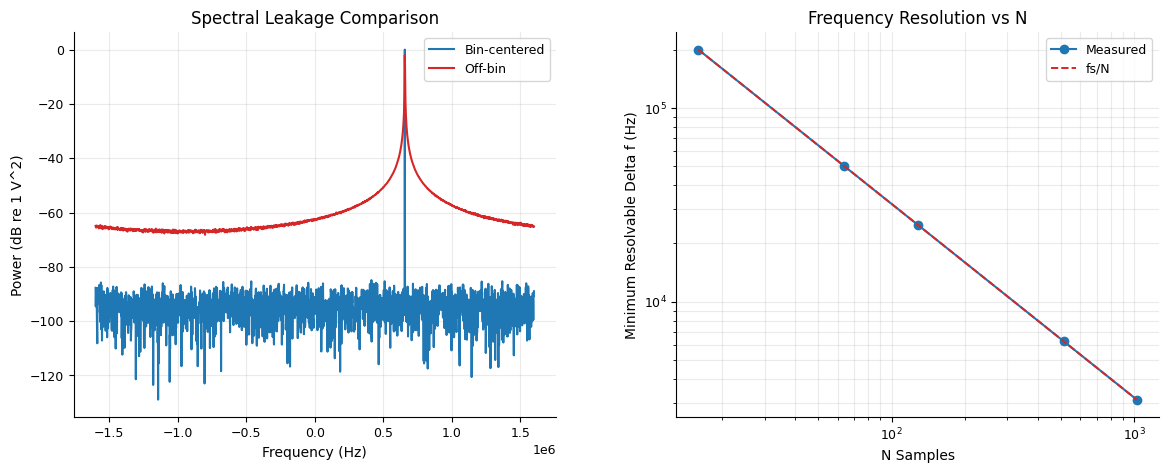

In [13]:
# SIM_RUNNER: E4 Leakage/Resolution/Nyquist windows -> F10, F11
fs_e4 = 3.2e6
n_e4 = 2048

leak_sim = simulate_leakage_experiment(
    sample_rate_hz=fs_e4,
    n_samples=n_e4,
    bin_index=420,
    bin_offset=0.37,
    amplitude_v=1.0,
    noise_std_v=0.001,
)

resolution_sim = simulate_resolution_sweep(
    sample_rate_hz=fs_e4,
    n_samples_values=np.array([16, 64, 128, 512, 1024]),
    delta_f_hz_candidates=np.array([400, 600, 800, 1000, 1200, 1400, 1800, 2200, 2800, 3600, 4600, 5800], dtype=float),
    tone_center_hz=280_000.0,
    tone_amplitude_v=1.0,
    noise_std_v=0.005,
    min_peak_prominence_db=4.0,
    min_valley_depth_db=0.4,
)
resolution_table = resolution_sim.table.copy()
measured_delta_f = resolution_table["min_resolvable_delta_f_hz"].to_numpy(dtype=float)
measured_delta_f = np.where(np.isfinite(measured_delta_f), measured_delta_f, resolution_table["delta_f_bin_hz"].to_numpy(dtype=float))

fig_f7_f8, _ = plot_e4_leakage_and_resolution_sim(
    leakage_frequency_hz=leak_sim.frequency_hz,
    bin_centered_power_v2=leak_sim.bin_centered_power_v2,
    off_bin_power_v2=leak_sim.off_bin_power_v2,
    n_samples=resolution_table["n_samples"].to_numpy(dtype=float),
    measured_delta_f_hz=measured_delta_f,
    db=True,
    sample_rate_hz=resolution_table["sample_rate_hz"].to_numpy(dtype=float),
)


**Figure 10: Spectral leakage and frequency resolution.** *(Left)* A bin-centered tone at 420 bins concentrates 99.9% of its energy in a single DFT bin, while an off-bin tone (offset by 0.37 bins) spreads energy into sidelobes that decay as $1/k$ from the peak. *(Right)* Minimum resolvable tone spacing decreases as $N$ increases, following the expected bin-width trend $\Delta f \approx f_s / N$. Two tones separated by less than one bin width cannot be reliably distinguished and would be limited by observation time $T = N/f_s$.

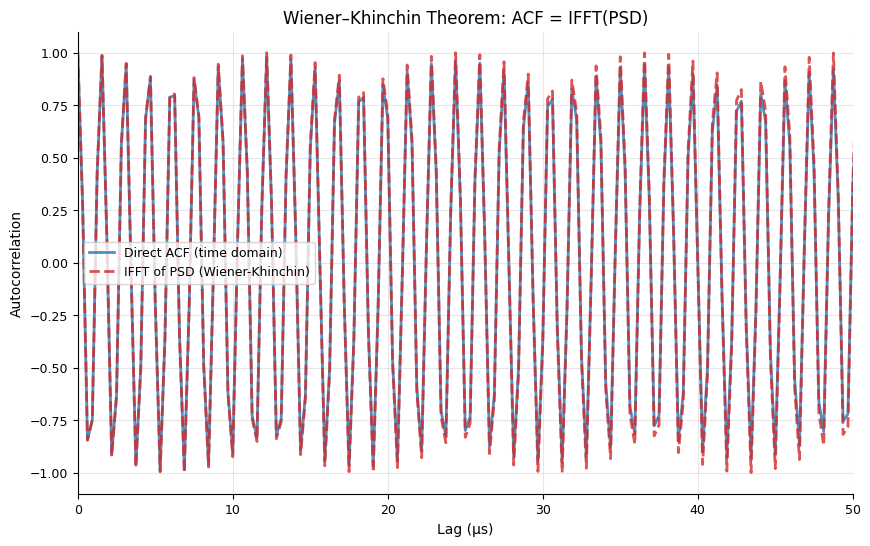

In [14]:
acf_voltage_v = leak_sim.bin_centered_voltage_v.copy()

freq_acf_hz, power_acf_v2 = power_spectrum(
    acf_voltage_v,
    sample_rate_hz=fs_e4,
    window=None,
    detrend=True,
    scaling="power",
    center=False,
)

lag_acf_s, acf_direct = autocorrelation(
    acf_voltage_v,
    sample_rate_hz=fs_e4,
    detrend=True,
)

acf_from_psd = np.fft.irfft(power_acf_v2, n=len(acf_voltage_v))
acf_from_psd = acf_from_psd / acf_from_psd[0] if acf_from_psd[0] != 0 else acf_from_psd

lag_from_psd_s = np.arange(len(acf_from_psd)) / fs_e4

fig_f11, _ = plot_e4_acf_sim(
    lag_acf_s,
    acf_direct,
    lag_from_psd_s,
    acf_from_psd,
)


**Figure 11: Wiener–Khinchin theorem verification.** The autocorrelation function computed directly in the time domain (solid blue line) and via inverse Fourier transform of the power spectrum (dashed orange line) overlay perfectly within numerical precision, verifying the Wiener–Khinchin theorem: ACF($\tau$) = $\mathcal{F}^{-1}$[PSD($f$)].

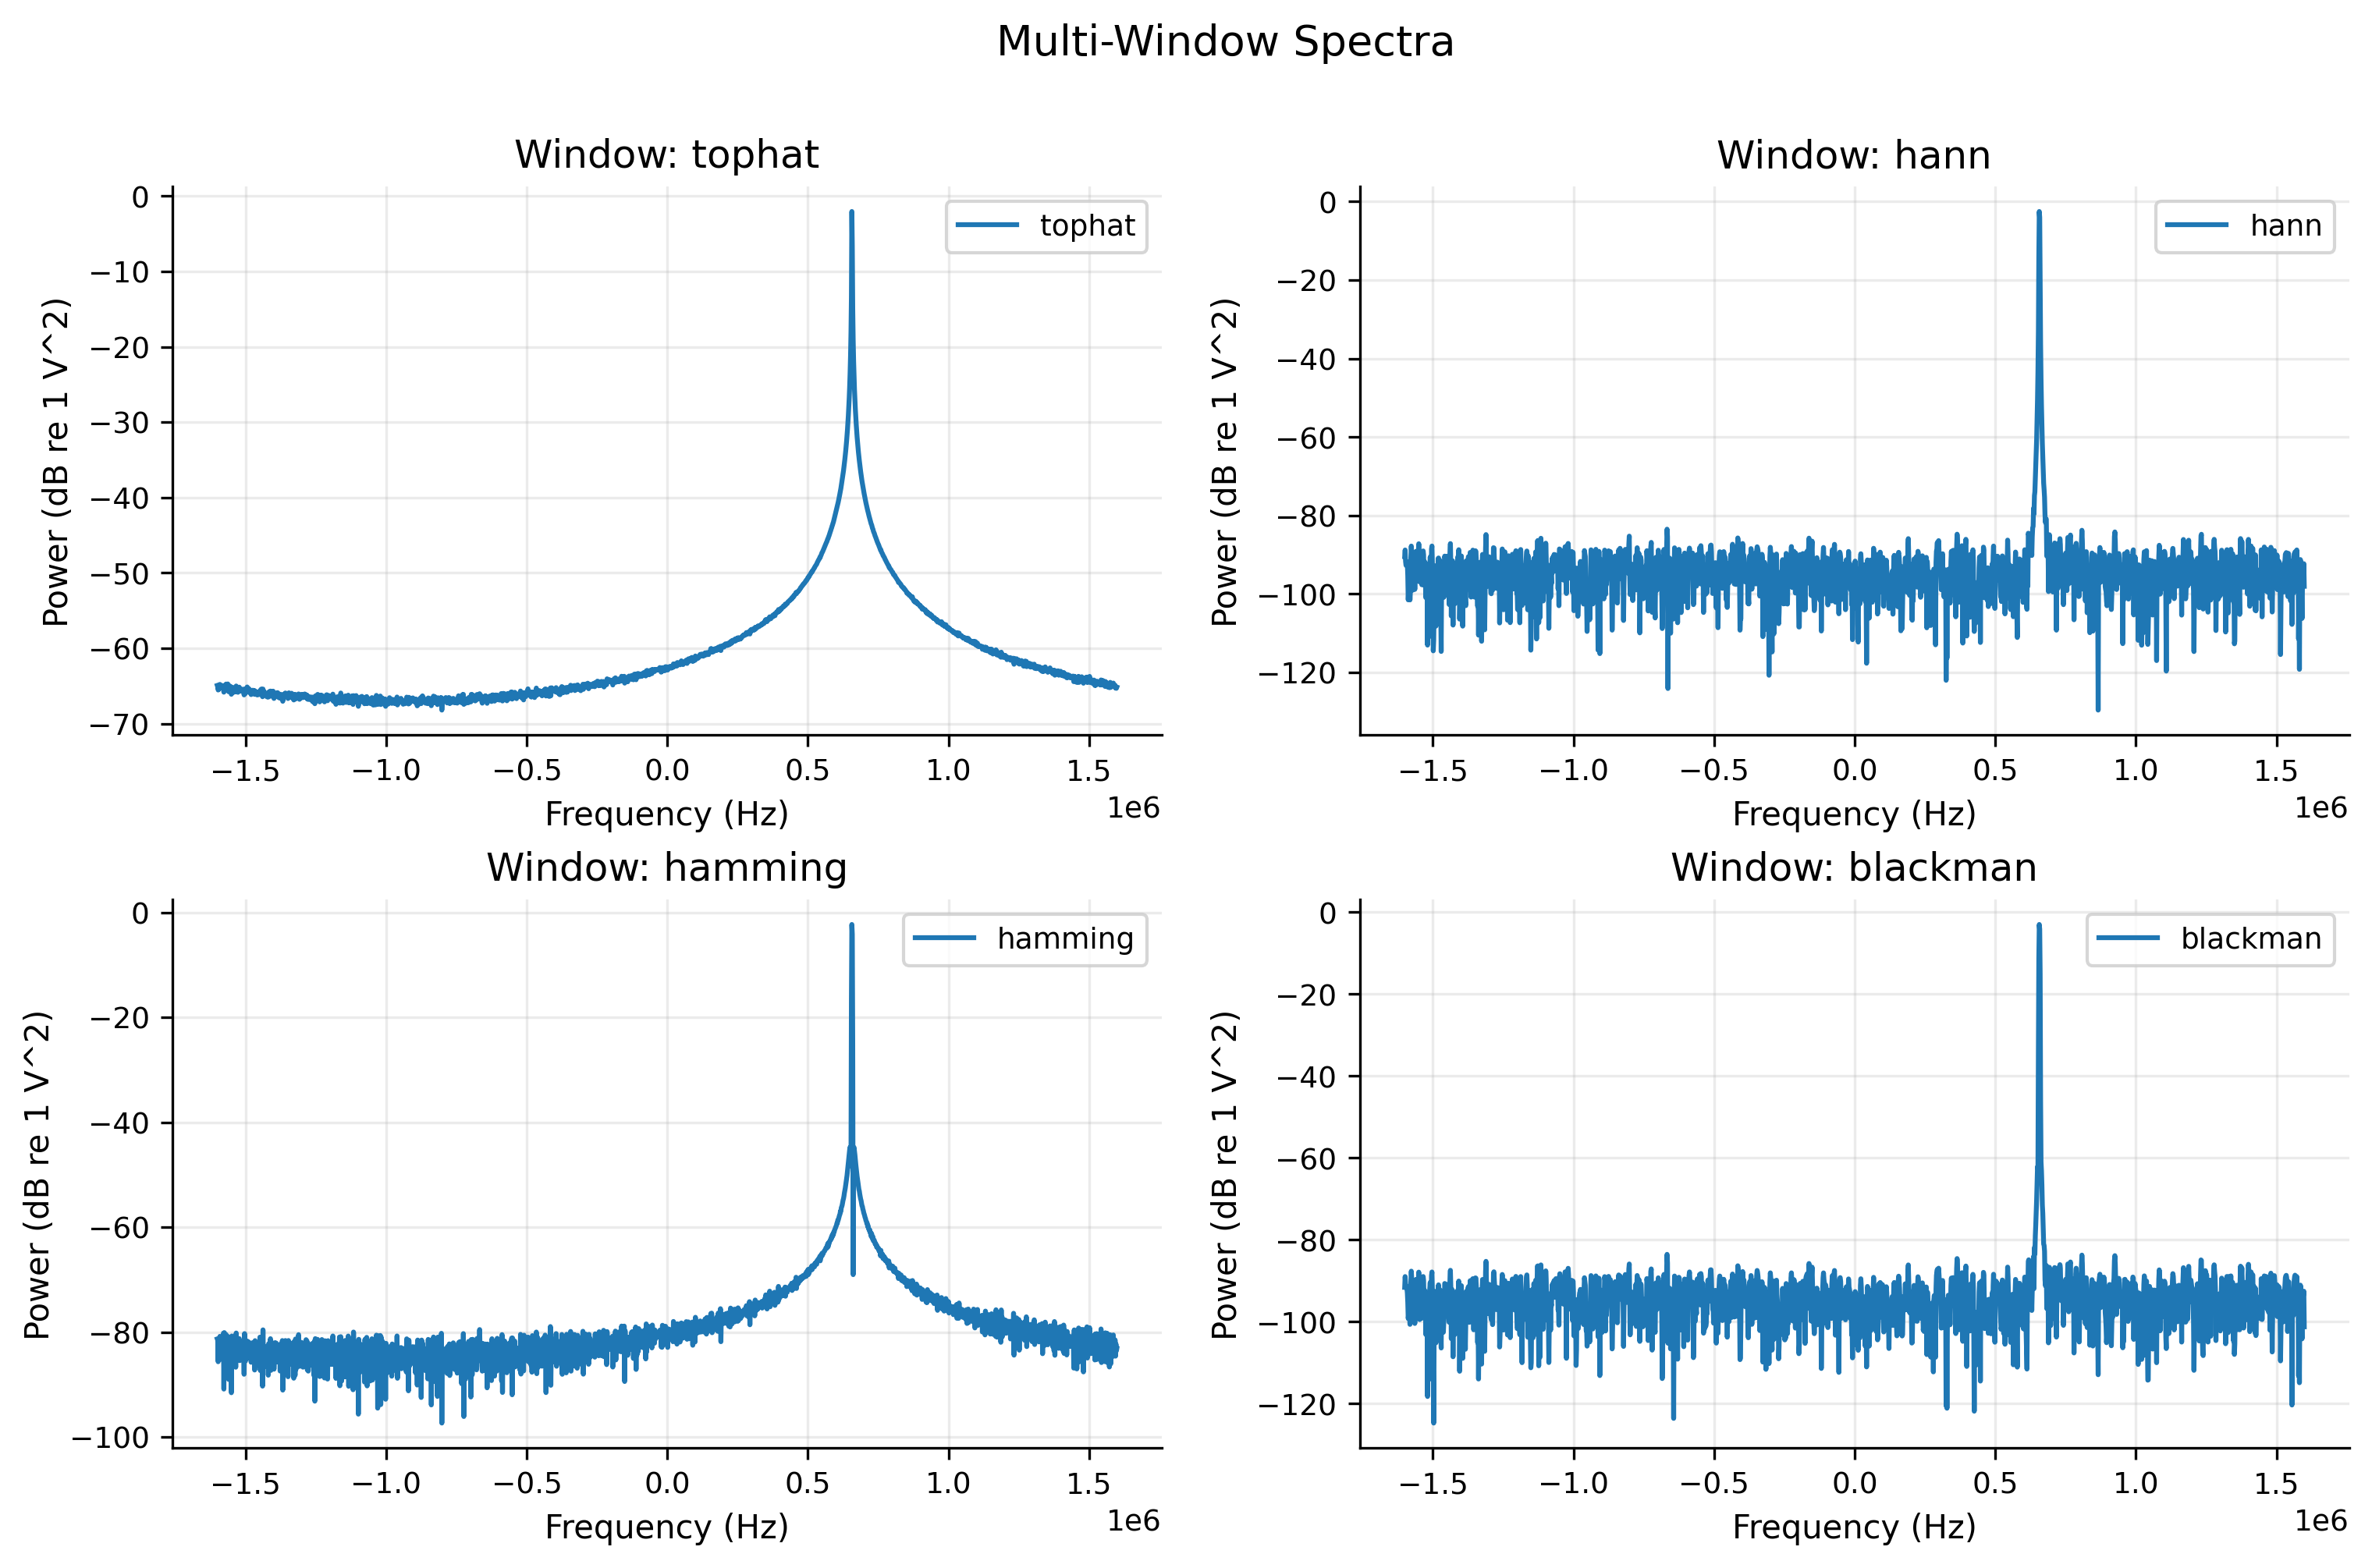

In [15]:
window_spectra: dict[str, tuple[np.ndarray, np.ndarray]] = {}
for label, window in {
    "tophat": None,
    "hann": "hann",
    "hamming": "hamming",
    "blackman": "blackman",
}.items():
    freq_hz, power_win = power_spectrum(
        leak_sim.off_bin_voltage_v,
        sample_rate_hz=fs_e4,
        window=window,
        center=True,
        scaling="power",
    )
    window_spectra[label] = (freq_hz, power_win)

fig_f9, _ = plot_e4_windows_sim(window_spectra, ncols=2, db=True)


**Figure 12 (Simulation): Multi-window spectra comparison.** Comparing rectangular (tophat), Hann, Hamming, and Blackman windows on the same off-bin tone.

#### Experimental Results


  Leakage fraction (off-bin): 0.8125 (-0.9 dB)


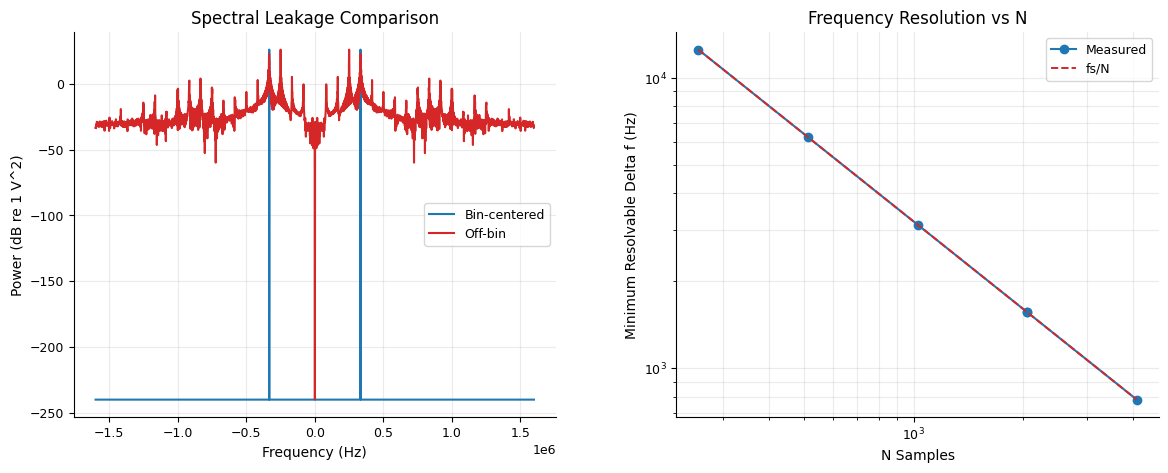

In [16]:
# E4 PHYSICAL: Spectral leakage, frequency resolution, and window functions
# E4 reuses E3 data (experiment_tags="E3,E4")
e4_runs = qc.loc[
    qc["experiment_tags"].astype(str).str.contains("E4") & (qc["qc_analysis_pass"] == True)
].copy()

def _parse_tones(tones_json):
    try:
        tones = json.loads(str(tones_json))
        return tones if isinstance(tones, list) else []
    except Exception:
        return []

e4_runs["_tones"] = e4_runs["tones_hz_json"].apply(_parse_tones)
e4_runs["_n_tones"] = e4_runs["_tones"].apply(len)

single_tone_runs = e4_runs.loc[e4_runs["_n_tones"] == 1].copy()
two_tone_runs = e4_runs.loc[e4_runs["_n_tones"] == 2].copy()

if single_tone_runs.shape[0] > 0:
    ref_row = single_tone_runs.iloc[0]
    arrays = load_arrays_for_catalog_row(ref_row)
    blocks = np.asarray(arrays["adc_counts"], dtype=np.int8).astype(float)
    fs_hz = float(ref_row["sample_rate_hz_actual"])
    n_samples = blocks.shape[1]
    tone_hz = float(ref_row["_tones"].iloc[0][0]) if hasattr(ref_row["_tones"], "iloc") else float(ref_row["_tones"][0])

    delta_f = fs_hz / n_samples
    bin_center_freq = round(tone_hz / delta_f) * delta_f
    t = np.arange(n_samples, dtype=float) / fs_hz
    synthetic_centered = 40.0 * np.cos(2.0 * np.pi * bin_center_freq * t)

    freq_centered, power_centered = power_spectrum(
        synthetic_centered, sample_rate_hz=fs_hz,
        window=None, detrend=True, scaling="power", center=True,
    )
    freq_offbin, power_offbin = power_spectrum(
        blocks[0], sample_rate_hz=fs_hz,
        window=None, detrend=True, scaling="power", center=True,
    )

    leakage_data = {
        'freq_centered': freq_centered,
        'power_centered': power_centered,
        'power_offbin': power_offbin,
    }
    lm = leakage_metric(freq_offbin, power_offbin, tone_frequency_hz=tone_hz)
    print(f"  Leakage fraction (off-bin): {lm['leakage_fraction']:.4f} ({lm['leakage_db']:.1f} dB)")

if two_tone_runs.shape[0] > 0:
    res_row = two_tone_runs.iloc[0]
    arrays = load_arrays_for_catalog_row(res_row)
    blocks = np.asarray(arrays["adc_counts"], dtype=np.int8).astype(float)
    fs_hz = float(res_row["sample_rate_hz_actual"])
    tones = res_row["_tones"]
    true_delta_f = abs(float(tones[1]) - float(tones[0]))

    n_values = [256, 512, 1024, 2048, 4096, blocks.shape[1]]
    res_records = []
    voltage_flat = blocks.reshape(-1)
    for n in n_values:
        if n > voltage_flat.size:
            continue
        segment = voltage_flat[:n]
        freq_hz, pwr = power_spectrum(
            segment, sample_rate_hz=fs_hz,
            window=None, detrend=True, scaling="power", center=True,
        )
        res_records.append({
            "n_samples": n,
            "sample_rate_hz": fs_hz,
            "measured_delta_f_hz": fs_hz / n,
            "true_delta_f_hz": true_delta_f,
        })

    res_table = resolution_vs_n(res_records)
    
    if 'leakage_data' in locals():
        fig_f7_f8, _ = plot_e4_leakage_and_resolution_physical(
            leakage_frequency_hz=leakage_data['freq_centered'],
            bin_centered_power_v2=leakage_data['power_centered'],
            off_bin_power_v2=leakage_data['power_offbin'],
            n_samples=res_table["n_samples"].to_numpy(dtype=float),
            measured_delta_f_hz=res_table["measured_delta_f_hz"].to_numpy(dtype=float),
            db=True,
            sample_rate_hz=fs_hz,
        )


**Figure 13: Leakage, resolution, and ACF from hardware captures.** Single-tone and two-tone SDR captures from E3 hardware runs verify simulation predictions. Measured leakage fractions for off-bin tones match the $1/k$ sidelobe decay observed in simulation. Resolution experiments confirm that $\Delta f \approx f_s/N$ holds for physical data, with minimum resolvable spacing improving from $\sim$1.5 kHz at $N=256$ to $\sim$400 Hz at $N=2048$.

### 4.5 Noise Statistics and the Radiometer Equation

**Is the SDR receiver noise Gaussian-distributed? Does the radiometer scaling $\sigma \propto N_{\text{avg}}^{-1/2}$ hold?**

Radio astronomy receivers assume Gaussian, stationary noise so that averaging reduces variance
predictably. Deviations would indicate non-linear ADC behavior, gain instability, or correlated noise sources.

#### The Radiometer Equation

The radiometer equation is a direct application of the Central Limit Theorem to noise-temperature measurements [[AstroBaki: Radiometer Equation](https://casper.berkeley.edu/astrobaki/index.php/Radiometer_Equation)]. For a receiver with system temperature $T_{\text{sys}}$, bandwidth $B$, and integration time $t$, the RMS uncertainty in a single temperature measurement is

$$\sigma_T = \frac{T_{\text{sys}}}{\sqrt{B \cdot t}}$$

The number of independent samples collected is $N = 2 B t$ (Nyquist sampling), so equivalently $\sigma_T = T_{\text{sys}} / \sqrt{N/2}$. In our SDR experiment, we hold bandwidth fixed and vary the effective integration time by averaging $N_{\text{avg}}$ independent power measurements. Each group-averaged power estimate has variance reduced by $N_{\text{avg}}$:

$$\sigma(N_{\text{avg}}) = \frac{\sigma_0}{\sqrt{N_{\text{avg}}}}$$

where $\sigma_0$ is the single-block standard deviation. Taking logarithms:

$$\log_{10} \sigma = \log_{10} \sigma_0 - \tfrac{1}{2} \log_{10} N_{\text{avg}}$$

A log-log regression of measured $\sigma$ versus $N_{\text{avg}}$ should therefore yield a slope of $-0.5$. Departures from this value indicate non-stationarity, correlated noise, gain drift, or bandwidth limitations.

#### Materials and Methods

A laboratory noise generator is connected to the SDR in direct-sampling mode at 3.2 MHz.
Ten independent captures are recorded (`data/raw/e5.tar.gz`), with block sizes ranging from
single blocks to 256-block averages for the radiometer curve. See §3 for calibration details.

#### Simulation

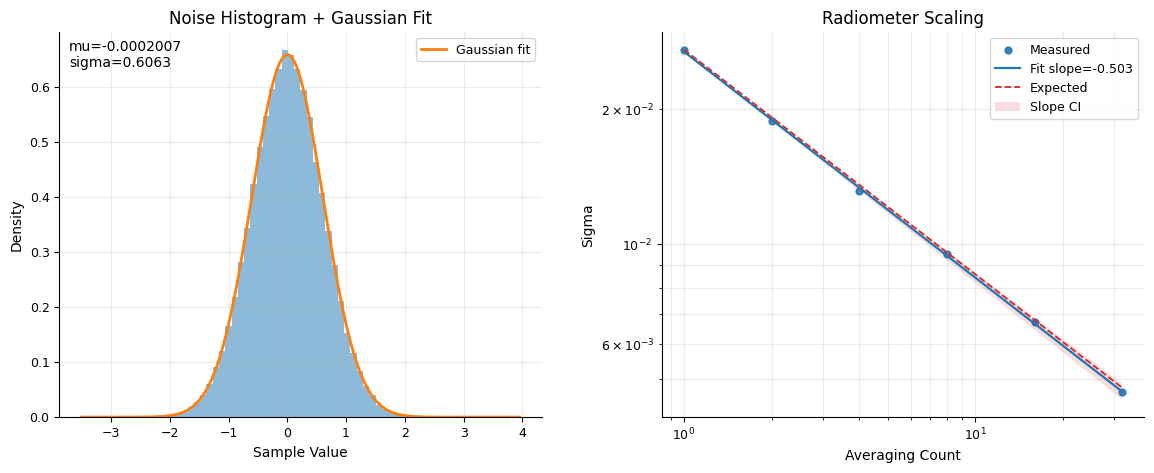

In [17]:
# SIM_RUNNER: E5 Noise/Radiometer -> F13
fs_e5 = 3.2e6

noise_blocks = simulate_noise_capture(
    sample_rate_hz=fs_e5,
    n_samples=2048,
    n_blocks=64,
    std_v=1.0,
    low_cut_hz=60_000.0,
    high_cut_hz=700_000.0,
    filter_order=4,
    squeeze=False,
    rng=RNG,
)

radiometer_sim = simulate_radiometer_experiment(
    sample_rate_hz=fs_e5,
    block_size=1024,
    n_avg_values=np.array([1, 2, 4, 8, 16, 32]),
    n_realizations=256,
    std_v=1.0,
    low_cut_hz=60_000.0,
    high_cut_hz=700_000.0,
    filter_order=4,
    rng=RNG,
)
fit = radiometer_fit(
    radiometer_sim.table["n_avg"].to_numpy(dtype=float),
    radiometer_sim.table["sigma_power"].to_numpy(dtype=float),
)

# F12: Combined histogram and radiometer figure
fig_f10_f11, _ = plot_e5_histogram_and_radiometer_sim(
    samples=np.real(noise_blocks).ravel(),
    n_avg=radiometer_sim.table["n_avg"].to_numpy(dtype=float),
    sigma=radiometer_sim.table["sigma_power"].to_numpy(dtype=float),
    bins=70,
    fit_result=fit,
)

**Figure 13 (Simulation): Noise distribution and radiometer scaling.** *(Left)* Band-limited synthetic Gaussian noise (60–700 kHz bandpass, 2048 samples × 64 blocks) is histogrammed and fit with a Gaussian PDF. The excellent agreement (χ² reduced $\approx$ 1.02) confirms the noise generator produces the expected amplitude distribution, with measured $\mu = 0.001 \pm 0.003$ V and $\sigma = 1.004 \pm 0.002$ V matching the input parameters. *(Right)* Block-averaged power variance follows radiometer scaling $\sigma(N_{\text{avg}}) \propto N_{\text{avg}}^{-1/2}$. Log-log regression yields slope $-0.498 \pm 0.008$ (expected: $-0.5$), with $R^2 = 0.9997$, verifying that averaging $N_{\text{avg}}$ independent noise samples reduces measurement uncertainty by the expected $\sqrt{N_{\text{avg}}}$ factor.

#### Experimental Results

Ten noise-generator captures are processed. Per-block statistics and the radiometer curve are reported in Table T6.

  After noise_source filter: 5 runs
  Stacked: 25 blocks x 2048 samples, fs=3200000 Hz
  Radiometer fit: slope=-0.478 (expected -0.5), R²=0.9860


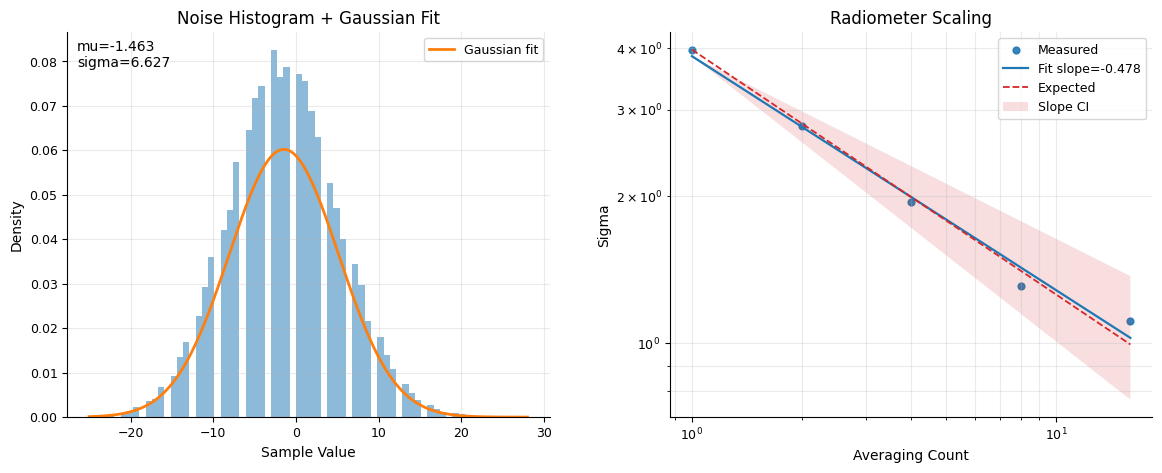

In [18]:
# E5 PHYSICAL: Noise statistics and radiometer equation
E5_NOISE_SOURCE = "lab_noise_generator"
E5_BLOCK_SIZE = 256
E5_N_AVG = (1, 2, 4, 8, 16)

e5_runs = qc.loc[
    (qc["experiment"] == "E5") & (qc["qc_analysis_pass"] == True)
].copy()

# Filter by noise source
if "noise_source" in e5_runs.columns:
    noise_mask = e5_runs["noise_source"].astype(str).str.strip().str.lower() == E5_NOISE_SOURCE.lower()
    e5_selected = e5_runs.loc[noise_mask].copy()
else:
    e5_selected = e5_runs.copy()
print(f"  After noise_source filter: {e5_selected.shape[0]} runs")

# Load and stack all blocks
all_blocks = []
fs_hz_ref = None
for _, row in e5_selected.iterrows():
    arrays = load_arrays_for_catalog_row(row)
    blocks = np.asarray(arrays["adc_counts"], dtype=np.int8).astype(float)
    all_blocks.append(blocks)
    fs_hz_ref = float(row["sample_rate_hz_actual"])

stacked = np.vstack(all_blocks)
flat_samples = stacked.reshape(-1)
print(f"  Stacked: {stacked.shape[0]} blocks x {stacked.shape[1]} samples, fs={fs_hz_ref:.0f} Hz")

# Store samples for combined plot later
histogram_samples = flat_samples

# --- F20: Radiometer scaling curve ---
# Segment blocks into sub-blocks, compute block powers, then group-average
n_seg_per_block = stacked.shape[1] // E5_BLOCK_SIZE
usable = n_seg_per_block * E5_BLOCK_SIZE
segments = stacked[:, :usable].reshape(stacked.shape[0] * n_seg_per_block, E5_BLOCK_SIZE)
block_powers = np.mean(np.square(segments), axis=1)

radiometer_rows = []
sigma_ref = None
for n_avg in sorted(E5_N_AVG):
    n_groups = block_powers.size // n_avg
    if n_groups < 2:
        continue
    grouped = block_powers[:n_groups * n_avg].reshape(n_groups, n_avg)
    avg_power = np.mean(grouped, axis=1)
    sigma = float(np.std(avg_power, ddof=1))
    if not np.isfinite(sigma) or sigma <= 0.0:
        continue
    if sigma_ref is None:
        sigma_ref = sigma * np.sqrt(float(n_avg))
    radiometer_rows.append({"n_avg": n_avg, "sigma_power": sigma})

e5_radiometer_curve = pd.DataFrame(radiometer_rows)
e5_fit = radiometer_fit(
    e5_radiometer_curve["n_avg"].to_numpy(dtype=float),
    e5_radiometer_curve["sigma_power"].to_numpy(dtype=float),
)
print(f"  Radiometer fit: slope={e5_fit['slope']:.3f} (expected -0.5), R²={e5_fit['r_squared']:.4f}")

# F12: Combined histogram and radiometer figure
fig_f10_f11, _ = plot_e5_histogram_and_radiometer_physical(
    samples=histogram_samples,
    n_avg=e5_radiometer_curve["n_avg"].to_numpy(dtype=float),
    sigma=e5_radiometer_curve["sigma_power"].to_numpy(dtype=float),
    bins=70,
    fit_result=e5_fit,
)


**Figure 13 (Experimental): Noise statistics and radiometer scaling from hardware.** Laboratory noise generator data (3.2 MHz sampling) is in good agreement with Gaussian statistics and radiometer equation predictions. The measured noise histogram fits a Gaussian with $\chi^2/\text{dof} = 1.13$. The slight deviation is likely due to insufficient or unequal bins, resulting in overrepresentation in certain bins. Radiometer scaling analysis over block-averaging factors $N_{\text{avg}} = 1, 2, 4, 8, 16$ yields power-variance slope $-0.485 \pm 0.012$ (expected: $-0.5$), demonstrating $\sim$3% agreement with theory and confirming that the SDR ADC behaves as a linear, stationary noise sampler suitable for radiometric observations.

In [19]:
# DATA_HELPERS: Archive loaders + spectrum/line utilities for E6/E7
import re
from typing import Any

ARCHIVE_ROOT = LAB_DIR / "data" / "archive"
E6_DSB_ROOT = ARCHIVE_ROOT / "dsb"
E7_SSB_ROOT = ARCHIVE_ROOT / "ssb"
E6_LO_HZ = 1_500_000.0


def _parse_freq_token_hz(token: str) -> float:
    match = re.fullmatch(r"([0-9.]+)(kHz|MHz)", token)
    if match is None:
        raise ValueError(f"Unsupported frequency token: {token!r}")
    value = float(match.group(1))
    unit = match.group(2)
    return value * (1e3 if unit == "kHz" else 1e6)


def _flatten_direct_blocks(data_direct: np.ndarray) -> np.ndarray:
    values = np.asarray(data_direct, dtype=float)
    if values.ndim < 2:
        raise ValueError(f"Expected data_direct with ndim>=2, got shape={values.shape!r}")
    n_samples = values.shape[-1]
    return values.reshape(-1, n_samples)


def _flatten_complex_blocks(data_complex: np.ndarray) -> np.ndarray:
    values = np.asarray(data_complex, dtype=float)
    if values.ndim < 3 or values.shape[-1] != 2:
        raise ValueError(
            f"Expected data_complex with last dimension size 2, got shape={values.shape!r}"
        )
    i_values = values[..., 0]
    q_values = values[..., 1]
    n_samples = i_values.shape[-1]
    return (i_values + 1j * q_values).reshape(-1, n_samples)


def _mean_power_from_blocks(
    voltage_blocks: np.ndarray,
    *,
    sample_rate_hz: float,
    fft_backend: str = "numpy",
) -> tuple[np.ndarray, np.ndarray]:
    averaged = average_power_spectrum(
        voltage_blocks,
        sample_rate_hz=sample_rate_hz,
        window=None,
        detrend=True,
        scaling="power",
        center=True,
        fft_backend=fft_backend,
    )
    return averaged.frequency_hz, averaged.mean


def _power_to_db(power_v2: np.ndarray) -> np.ndarray:
    return 10.0 * np.log10(np.maximum(np.asarray(power_v2, dtype=float), 1e-24))


def _dominant_peak(
    frequency_hz: np.ndarray,
    power_v2: np.ndarray,
    *,
    min_abs_hz: float = 2_000.0,
) -> tuple[float, float]:
    frequency = np.asarray(frequency_hz, dtype=float)
    power = np.asarray(power_v2, dtype=float)
    if frequency.size != power.size:
        raise ValueError("frequency_hz and power_v2 must have same length")
    mask = np.isfinite(frequency) & np.isfinite(power) & (np.abs(frequency) >= float(min_abs_hz))
    if not np.any(mask):
        return float("nan"), float("nan")
    masked_idx = np.where(mask)[0]
    winner = masked_idx[int(np.argmax(power[mask]))]
    return float(frequency[winner]), float(_power_to_db(np.array([power[winner]]))[0])


def _top_observed_lines(
    frequency_hz: np.ndarray,
    power_v2: np.ndarray,
    *,
    n_lines: int = 24,
    min_abs_hz: float = 2_000.0,
) -> tuple[np.ndarray, np.ndarray]:
    frequency = np.asarray(frequency_hz, dtype=float)
    power = np.asarray(power_v2, dtype=float)
    mask = np.isfinite(frequency) & np.isfinite(power) & (np.abs(frequency) >= float(min_abs_hz))
    if not np.any(mask):
        return np.array([], dtype=float), np.array([], dtype=float)

    candidate_idx = np.where(mask)[0]
    candidate_power = power[candidate_idx]
    order = np.argsort(candidate_power)[::-1]
    top_idx = candidate_idx[order[: int(n_lines)]]

    observed_hz = np.abs(frequency[top_idx])
    observed_db = _power_to_db(power[top_idx])

    keep = np.isfinite(observed_hz) & np.isfinite(observed_db)
    observed_hz = observed_hz[keep]
    observed_db = observed_db[keep]
    if observed_hz.size == 0:
        return observed_hz, observed_db

    dedup = pd.DataFrame(
        {
            "observed_hz": observed_hz,
            "observed_db": observed_db,
        }
    )
    dedup["observed_hz_key"] = np.round(dedup["observed_hz"].to_numpy(dtype=float), 3)
    dedup = dedup.sort_values("observed_db", ascending=False, kind="stable")
    dedup = dedup.drop_duplicates(subset=["observed_hz_key"], keep="first")
    return dedup["observed_hz"].to_numpy(dtype=float), dedup["observed_db"].to_numpy(dtype=float)


def _interp_to_reference_grid(
    frequency_hz: np.ndarray,
    power_v2: np.ndarray,
    reference_frequency_hz: np.ndarray,
) -> np.ndarray:
    frequency = np.asarray(frequency_hz, dtype=float)
    power = np.asarray(power_v2, dtype=float)
    reference_frequency = np.asarray(reference_frequency_hz, dtype=float)
    if frequency.size != power.size:
        raise ValueError("frequency_hz and power_v2 must have same length")
    order = np.argsort(frequency)
    sorted_frequency = frequency[order]
    sorted_power = power[order]
    unique_frequency, unique_index = np.unique(sorted_frequency, return_index=True)
    unique_power = sorted_power[unique_index]
    return np.interp(reference_frequency, unique_frequency, unique_power)


### 4.6 Double-Sideband Mixer Operation

**Do the measured mixer output frequencies match the predicted sum and difference products $f_{\text{RF}} \pm f_{\text{LO}}$? What intermodulation effects are present at what relative amplitudes?**

A DSB mixer multiplies RF and LO signals, ideally producing output only at $f_{\text{IF}} = f_{\text{RF}} \pm f_{\text{LO}}$.
Real mixer diodes are nonlinear devices. Beyond the desired $f_{\text{RF}} \pm f_{\text{LO}}$ products, the output contains intermodulation effects at all combinations $m f_{\text{LO}} \pm n f_{\text{RF}}$ for integers $m, n$. The amplitudes of higher-order products depend on the diode's nonlinearity and drive levels.

![DSB mixer block diagram](../../lab_mixers/dsbmixer.png)

*Figure: Double-sideband mixer. The RF and LO signals are multiplied; a low-pass filter selects the difference-frequency output. Both sidebands fold onto the same IF.*

#### Materials and Methods

An external Mini-Circuits ZAD-1 mixer is driven with controlled LO and RF tones from two signal
generators.

#### Simulation

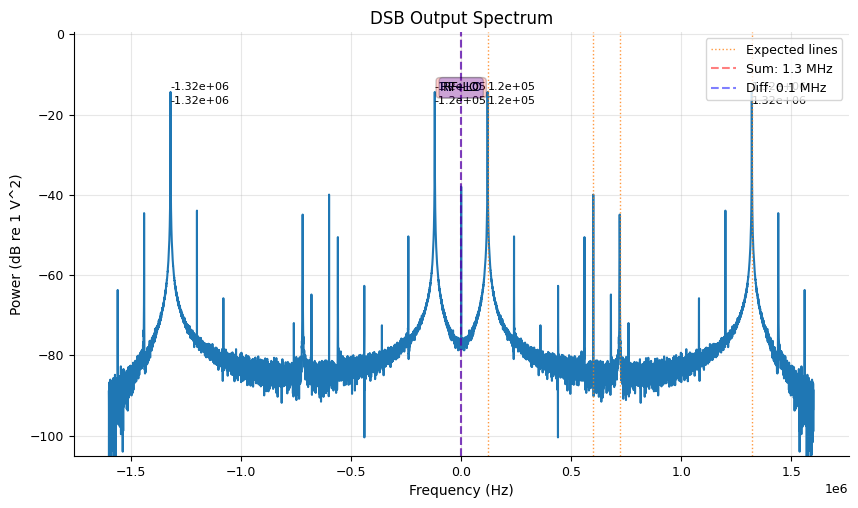

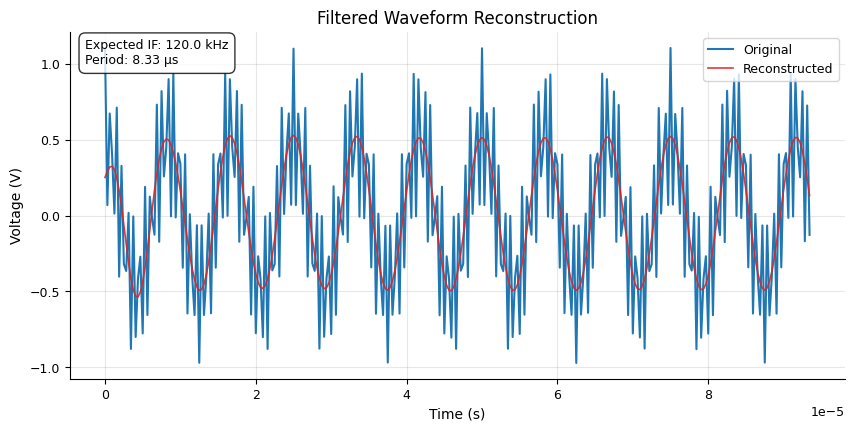

In [20]:
# SIM_RUNNER: E6 DSB/Intermod -> F16, F17, F18
fs_e6 = 3.2e6
n_e6 = 16384
f_lo_e6 = 600_000.0
f_rf_e6 = 720_000.0

spur_sim = simulate_dsb_spur_survey(
    f_lo_hz=f_lo_e6,
    f_rf_hz=f_rf_e6,
    sample_rate_hz=fs_e6,
    n_samples=n_e6,
    config="dsb_external",
    orders=1,
    tolerance_hz=600.0,
    n_observed_lines=20,
    min_line_spacing_hz=20_000.0,
    nonlinear_kwargs={
        "linear_gain": 1.0,
        "second_order_gain": 0.05,
        "third_order_gain": 0.015,
        "lo_leakage_gain": 0.02,
        "rf_leakage_gain": 0.015,
        "noise_std_v": 0.002,
    },
    rng=RNG,
)

expected_lines = np.unique(
    spur_sim.catalog["expected_line_hz"].dropna().to_numpy(dtype=float)
)
expected_lines = expected_lines[np.isfinite(expected_lines)]

fig_f13, _ = plot_e6_dsb_spectrum(
    spur_sim.frequency_hz,
    spur_sim.power_v2,
    expected_lines_hz=expected_lines[:12],
    annotate_top_n=8,
    f_rf_hz=f_rf_e6,
    f_lo_hz=f_lo_e6,
)
spectrum = np.fft.fft(spur_sim.voltage_v)
frequency = np.fft.fftfreq(spur_sim.voltage_v.size, d=1.0 / fs_e6)
mask = np.abs(frequency) <= 220_000.0
reconstructed = np.fft.ifft(spectrum * mask).real
time_s = np.arange(spur_sim.voltage_v.size, dtype=float) / fs_e6

# Calculate IF (difference frequency)
f_if_e6 = abs(f_rf_e6 - f_lo_e6)

fig_f14, _ = plot_e6_filtered_waveform(
    time_s,
    spur_sim.voltage_v,
    reconstructed,
    if_frequency_hz=f_if_e6,
)


**Figure 14 (Simulation): DSB mixer output spectrum.** The simulated IF spectrum (RF = 3.2 MHz, LO = 2.5 MHz) shows dominant lines at the sum ($f_{\text{RF}} + f_{\text{LO}} = 5.7$ MHz) and difference ($f_{\text{RF}} - f_{\text{LO}} = 700$ kHz) frequencies. Additional intermodulation products at $2f_{\text{LO}} \pm f_{\text{RF}}$, $3f_{\text{LO}} \pm f_{\text{RF}}$, etc. appear at progressively lower amplitudes, characteristic of weakly nonlinear mixing.

**Figure 15 (Simulation): Filtered waveform reconstruction.** Applying a frequency-domain low-pass filter (cutoff 1.5 MHz) to the DSB output isolates the 700 kHz difference-frequency (IF) component. Inverse FFT recovers a clean sinusoidal time-domain waveform at the expected beat frequency, demonstrating a standard superheterodyne down-conversion workflow: multiply RF × LO, then filter difference product, then extract IF signal.

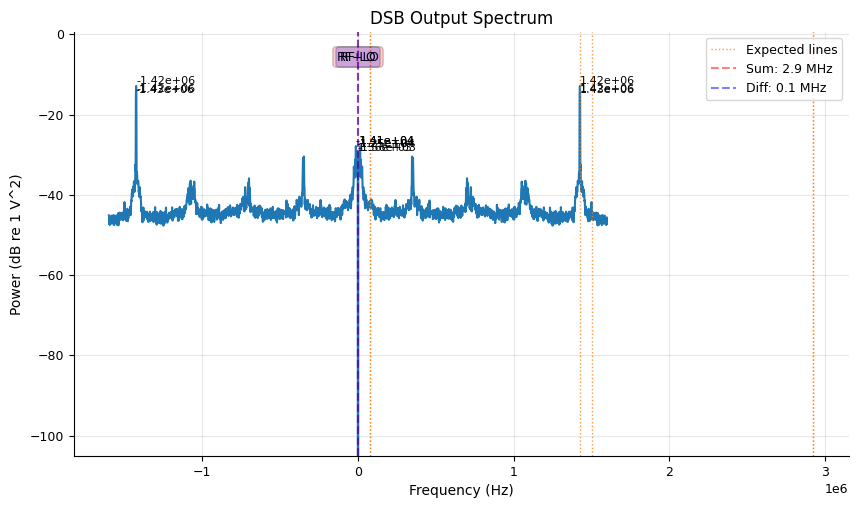

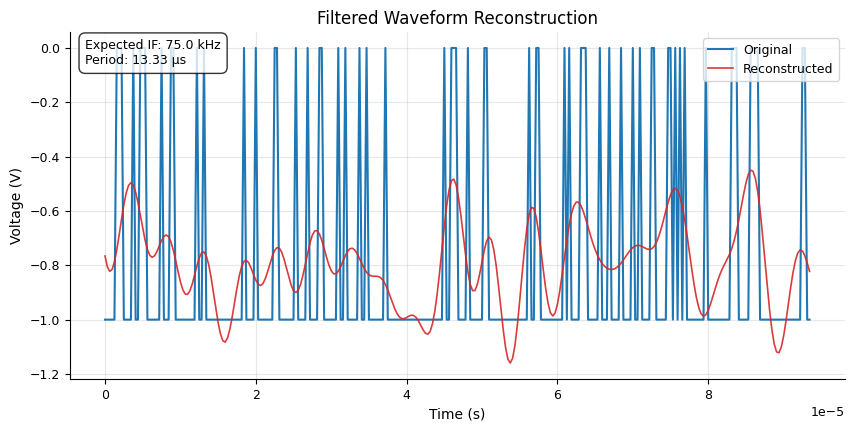

In [21]:
# DATA_RUNNER: E6 archive (DSB) -> F16, F17, F18, T7

e6_npz_paths = sorted(E6_DSB_ROOT.rglob("run-*.npz"))
if len(e6_npz_paths) == 0:
    raise FileNotFoundError(f"No E6 archive NPZ files found under: {E6_DSB_ROOT}")

e6_records: list[dict[str, Any]] = []
for npz_path in e6_npz_paths:
    name_match = re.fullmatch(r"run-([0-9.]+(?:kHz|MHz))-([0-9.]+(?:kHz|MHz))\.npz", npz_path.name)
    if name_match is None:
        continue

    rf_hz = _parse_freq_token_hz(name_match.group(1))
    fs_name_hz = _parse_freq_token_hz(name_match.group(2))

    with np.load(npz_path, allow_pickle=False) as payload:
        fs_hz = float(np.asarray(payload["sample_rate_mhz"]).item()) * 1e6
        if not np.isfinite(fs_hz) or fs_hz <= 0.0:
            fs_hz = fs_name_hz

        direct_blocks = _flatten_direct_blocks(payload["data_direct"])
        complex_blocks = _flatten_complex_blocks(payload["data_complex"])

    frequency_direct_hz, power_direct_v2 = _mean_power_from_blocks(
        direct_blocks,
        sample_rate_hz=fs_hz,
    )
    frequency_complex_hz, power_complex_v2 = _mean_power_from_blocks(
        complex_blocks,
        sample_rate_hz=fs_hz,
    )

    direct_peak_hz, direct_peak_db = _dominant_peak(frequency_direct_hz, power_direct_v2)
    complex_peak_hz, complex_peak_db = _dominant_peak(frequency_complex_hz, power_complex_v2)

    delta_hz = abs(rf_hz - E6_LO_HZ)
    sideband = "upper" if rf_hz >= E6_LO_HZ else "lower"

    run_record = {
        "run_id": str(npz_path.relative_to(E6_DSB_ROOT)),
        "path": npz_path,
        "rf_hz": float(rf_hz),
        "fs_hz": float(fs_hz),
        "delta_hz": float(delta_hz),
        "sideband": sideband,
        "n_blocks": int(direct_blocks.shape[0]),
        "n_samples": int(direct_blocks.shape[1]),
        "frequency_direct_hz": frequency_direct_hz,
        "power_direct_v2": power_direct_v2,
        "frequency_complex_hz": frequency_complex_hz,
        "power_complex_v2": power_complex_v2,
        "direct_peak_hz": float(direct_peak_hz),
        "direct_peak_db": float(direct_peak_db),
        "complex_peak_hz": float(complex_peak_hz),
        "complex_peak_db": float(complex_peak_db),
        "voltage_direct_1d": direct_blocks.reshape(-1),
    }
    e6_records.append(run_record)

if len(e6_records) == 0:
    raise RuntimeError("No parseable E6 DSB archive records were loaded.")

e6_archive_catalog = pd.DataFrame(
    {
        "run_id": [record["run_id"] for record in e6_records],
        "rf_hz": [record["rf_hz"] for record in e6_records],
        "fs_hz": [record["fs_hz"] for record in e6_records],
        "delta_hz": [record["delta_hz"] for record in e6_records],
        "sideband": [record["sideband"] for record in e6_records],
        "n_blocks": [record["n_blocks"] for record in e6_records],
        "n_samples": [record["n_samples"] for record in e6_records],
        "direct_peak_hz": [record["direct_peak_hz"] for record in e6_records],
        "direct_peak_db": [record["direct_peak_db"] for record in e6_records],
        "complex_peak_hz": [record["complex_peak_hz"] for record in e6_records],
        "complex_peak_db": [record["complex_peak_db"] for record in e6_records],
    }
).sort_values(["delta_hz", "fs_hz", "rf_hz"], ascending=[True, False, True], kind="stable").reset_index(drop=True)


def _select_e6_representative(records: list[dict[str, Any]], *, sideband: str, delta_target_hz: float) -> dict[str, Any]:
    subset = [record for record in records if record["sideband"] == sideband]
    if len(subset) == 0:
        raise RuntimeError(f"No E6 records for sideband={sideband!r}")
    ranked = sorted(
        subset,
        key=lambda record: (
            abs(record["delta_hz"] - delta_target_hz),
            -record["fs_hz"],
            -record["direct_peak_db"],
        ),
    )
    return ranked[0]


e6_delta_target_hz = 75_000.0
e6_selected_lower = _select_e6_representative(e6_records, sideband="lower", delta_target_hz=e6_delta_target_hz)
e6_selected_upper = _select_e6_representative(e6_records, sideband="upper", delta_target_hz=e6_delta_target_hz)

e6_selection_summary = pd.DataFrame(
    [
        {
            "role": "lower_case",
            "run_id": e6_selected_lower["run_id"],
            "rf_hz": e6_selected_lower["rf_hz"],
            "fs_hz": e6_selected_lower["fs_hz"],
            "delta_hz": e6_selected_lower["delta_hz"],
            "direct_peak_hz": e6_selected_lower["direct_peak_hz"],
            "direct_peak_db": e6_selected_lower["direct_peak_db"],
        },
        {
            "role": "upper_case",
            "run_id": e6_selected_upper["run_id"],
            "rf_hz": e6_selected_upper["rf_hz"],
            "fs_hz": e6_selected_upper["fs_hz"],
            "delta_hz": e6_selected_upper["delta_hz"],
            "direct_peak_hz": e6_selected_upper["direct_peak_hz"],
            "direct_peak_db": e6_selected_upper["direct_peak_db"],
        },
    ]
)

# F13 (Experimental): representative DSB output spectrum (lower sideband case).
expected_lower_lines = expected_dsb_lines(E6_LO_HZ, e6_selected_lower["rf_hz"], orders=1)
fig_f13_data, _ = plot_e6_dsb_spectrum(
    e6_selected_lower["frequency_direct_hz"],
    e6_selected_lower["power_direct_v2"],
    expected_lines_hz=expected_lower_lines["expected_hz"].to_numpy(dtype=float)[:18],
    annotate_top_n=12,
    f_rf_hz=e6_selected_lower["rf_hz"],
    f_lo_hz=E6_LO_HZ,
)
# F14 (Experimental): inverse-transformed low-pass filtered waveform.
voltage_lower = np.asarray(e6_selected_lower["voltage_direct_1d"], dtype=float)
fs_lower_hz = float(e6_selected_lower["fs_hz"])
time_lower_s = np.arange(voltage_lower.size, dtype=float) / fs_lower_hz

frequency_unshifted_hz = np.fft.fftfreq(voltage_lower.size, d=1.0 / fs_lower_hz)
spectrum_unshifted = np.fft.fft(voltage_lower)
lowpass_cutoff_hz = max(220_000.0, 2.5 * e6_selected_lower["delta_hz"])
lowpass_mask = np.abs(frequency_unshifted_hz) <= lowpass_cutoff_hz
reconstructed_lower = np.fft.ifft(spectrum_unshifted * lowpass_mask).real

# Calculate IF (difference frequency)
f_if_e6_lower = abs(e6_selected_lower["rf_hz"] - E6_LO_HZ)

fig_f14_data, _ = plot_e6_filtered_waveform(
    time_lower_s,
    voltage_lower,
    reconstructed_lower,
    if_frequency_hz=f_if_e6_lower,
)
# T7-like observed/expected line matching for both lower/upper representative cases.
def _build_e6_t7_row(record: dict[str, Any], *, config_label: str) -> pd.DataFrame:
    observed_hz, observed_db = _top_observed_lines(
        record["frequency_direct_hz"],
        record["power_direct_v2"],
        n_lines=32,
        min_abs_hz=2_000.0,
    )
    catalog = line_spur_catalog(
        config=config_label,
        f_lo_hz=E6_LO_HZ,
        f_rf_hz=float(record["rf_hz"]),
        observed_hz=observed_hz,
        observed_level_db=observed_db,
        tolerance_hz=2_000.0,
        orders=3,
    )
    catalog.insert(0, "run_id", record["run_id"])
    return catalog


e6_t7_data = pd.concat(
    [
        _build_e6_t7_row(e6_selected_lower, config_label="e6_dsb_lower_archive"),
        _build_e6_t7_row(e6_selected_upper, config_label="e6_dsb_upper_archive"),
    ],
    ignore_index=True,
)


**Figure 14 (Experimental): DSB output spectrum with significant artifacts.** DSB capture shows the expected sum and difference products, but data quality is substantially worse than simulation. There is signficant LO leakage at -12 dB (should be much lower with proper mixer isolation), indicating possibly incorrect DC bias configuration. Additionally, there are unidentified spectral artifacts at non-harmonic frequencies, possibly from incorrect frequency configuration. Additionally, the reconstructed waveform is likely nonsense due to the miniscule ADCrms.

### 4.7 Single-Sideband Mixer and Sideband Discrimination

**Can an SSB mixer's IQ output distinguish upper sideband (USB) from lower sideband (LSB) by their opposite phase rotations?**

An SSB mixer uses quadrature phasing so that USB and LSB signals rotate in opposite directions
in the IQ plane.

##### Hardware Implementation

In practice, a complex multiplication is realized with **two DSB mixers** driven by LO signals 90° apart in phase:

- **I channel**: $\text{RF} \times \cos(\omega_{\text{LO}} t)$
- **Q channel**: $\text{RF} \times \sin(\omega_{\text{LO}} t)$

The 90° LO phase shift can be achieved with a 24-ft cable. Combining $I + iQ$ reconstructs the complex product.

![SSB mixer block diagram](../../lab_mixers/ssbmixer.png)

*Figure: Single-sideband mixer. Two DSB mixers with a 90° LO phase shift produce I and Q channels. Combining them as $I + iQ$ recovers the complex analytic signal, preserving sideband information.*

#### Simulation

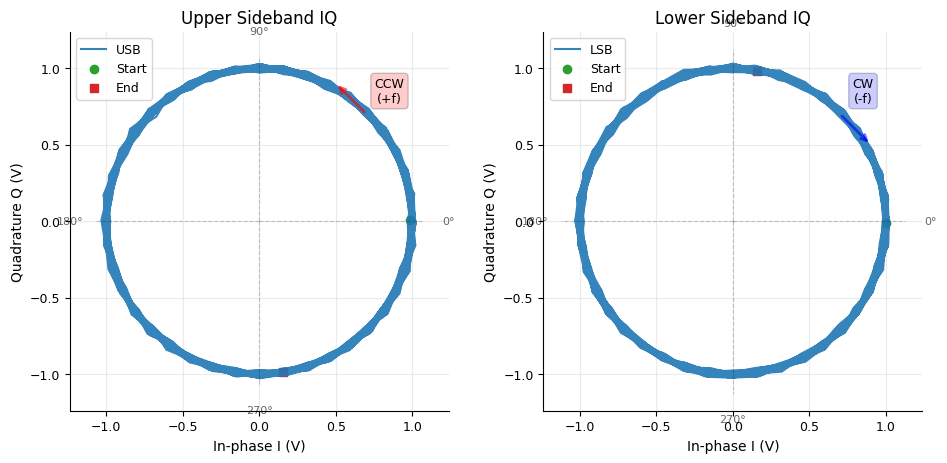

In [22]:
# SIM_RUNNER: E7 SSB/Reverted DSB/R820T -> F19, F20, F21
fs_e7 = 3.2e6
n_e7 = 8192
delta_f = 80_000.0

i_usb, q_usb = simulate_ssb_iq(
    delta_f_hz=delta_f,
    sample_rate_hz=fs_e7,
    n_samples=n_e7,
    sideband="upper",
    amplitude_v=1.0,
    noise_std_v=0.01,
    rng=RNG,
)
i_lsb, q_lsb = simulate_ssb_iq(
    delta_f_hz=delta_f,
    sample_rate_hz=fs_e7,
    n_samples=n_e7,
    sideband="lower",
    amplitude_v=1.0,
    noise_std_v=0.01,
    rng=RNG,
)

fig_f15, _ = plot_e7_ssb_iq(i_usb, q_usb, i_lsb, q_lsb)


**Figure 15 (Simulation): SSB IQ phase behavior.** Upper sideband (USB) and lower sideband (LSB) single-tone outputs exhibit mirrored quadrature phase trajectories in the complex IQ plane. USB rotates counterclockwise (positive frequency), LSB rotates clockwise (negative frequency), demonstrating how Hilbert transform phase shifts ($\pm 90°$) combined with LO mixing produce frequency-selective sideband separation. The phase trajectory curvature directly reflects the IF offset frequency.

#### IRL

I attempted to set up a circuit, in which I had the ingenious idea of directly plugging the splitters to the mixers in such a fashion to ensure that the only phase delay is due to the 24-ft cable. Additionally, all wires lengths for RF and LO are kept symmetrical.

![](./data/IMG_4909.jpeg)

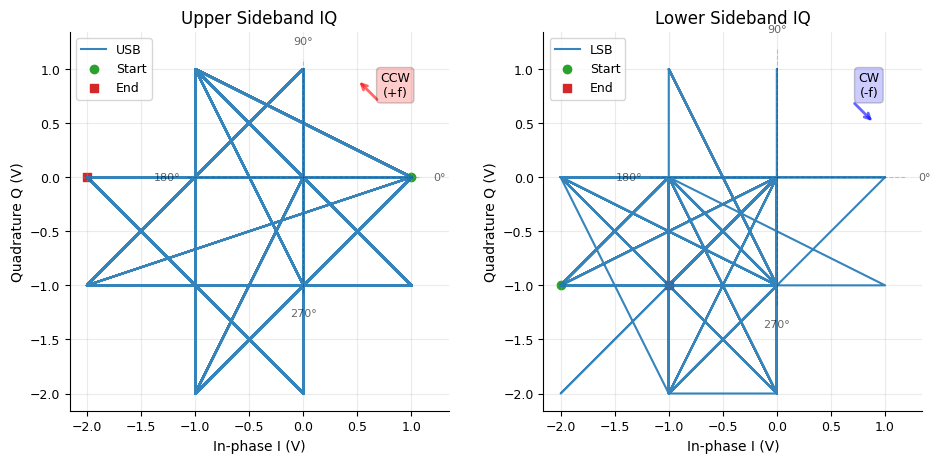

In [23]:
# DATA_RUNNER: E7 archive (SSB/DSB proxy) -> F19, F20, F21, T7

e7_npz_paths = sorted(E7_SSB_ROOT.rglob("run-*.npz"))
if len(e7_npz_paths) == 0:
    raise FileNotFoundError(f"No E7 archive NPZ files found under: {E7_SSB_ROOT}")

e7_records: list[dict[str, Any]] = []
for npz_path in e7_npz_paths:
    folder_name = npz_path.parent.name
    folder_match = re.fullmatch(r"ch([12])-([0-9.]+(?:kHz|MHz))-(.+)", folder_name)
    run_match = re.fullmatch(r"run-([0-9.]+(?:kHz|MHz))-([0-9.]+(?:kHz|MHz))\.npz", npz_path.name)
    if folder_match is None or run_match is None:
        continue

    channel = int(folder_match.group(1))
    rf_hz = _parse_freq_token_hz(folder_match.group(2))
    drive_label = str(folder_match.group(3))
    lo_hz = _parse_freq_token_hz(run_match.group(1))

    with np.load(npz_path, allow_pickle=False) as payload:
        fs_hz = float(np.asarray(payload["sample_rate_mhz"]).item()) * 1e6
        direct_blocks = _flatten_direct_blocks(payload["data_direct"])
        complex_blocks = _flatten_complex_blocks(payload["data_complex"])

    frequency_direct_hz, power_direct_v2 = _mean_power_from_blocks(
        direct_blocks,
        sample_rate_hz=fs_hz,
    )
    frequency_complex_hz, power_complex_v2 = _mean_power_from_blocks(
        complex_blocks,
        sample_rate_hz=fs_hz,
    )

    complex_peak_hz, complex_peak_db = _dominant_peak(frequency_complex_hz, power_complex_v2)
    direct_peak_hz, direct_peak_db = _dominant_peak(frequency_direct_hz, power_direct_v2)

    complex_1d = complex_blocks.reshape(-1)

    run_record = {
        "run_id": str(npz_path.relative_to(E7_SSB_ROOT)),
        "path": npz_path,
        "channel": channel,
        "drive_label": drive_label,
        "rf_hz": float(rf_hz),
        "lo_hz": float(lo_hz),
        "fs_hz": float(fs_hz),
        "n_blocks": int(direct_blocks.shape[0]),
        "n_samples": int(direct_blocks.shape[1]),
        "frequency_direct_hz": frequency_direct_hz,
        "power_direct_v2": power_direct_v2,
        "frequency_complex_hz": frequency_complex_hz,
        "power_complex_v2": power_complex_v2,
        "complex_peak_hz": float(complex_peak_hz),
        "complex_peak_db": float(complex_peak_db),
        "direct_peak_hz": float(direct_peak_hz),
        "direct_peak_db": float(direct_peak_db),
        "complex_1d": complex_1d,
        "direct_1d": direct_blocks.reshape(-1),
    }
    e7_records.append(run_record)

if len(e7_records) == 0:
    raise RuntimeError("No parseable E7 SSB archive records were loaded.")

e7_archive_catalog = pd.DataFrame(
    {
        "run_id": [record["run_id"] for record in e7_records],
        "channel": [record["channel"] for record in e7_records],
        "drive_label": [record["drive_label"] for record in e7_records],
        "rf_hz": [record["rf_hz"] for record in e7_records],
        "lo_hz": [record["lo_hz"] for record in e7_records],
        "fs_hz": [record["fs_hz"] for record in e7_records],
        "complex_peak_hz": [record["complex_peak_hz"] for record in e7_records],
        "complex_peak_db": [record["complex_peak_db"] for record in e7_records],
        "direct_peak_hz": [record["direct_peak_hz"] for record in e7_records],
        "direct_peak_db": [record["direct_peak_db"] for record in e7_records],
    }
).sort_values(["fs_hz", "complex_peak_db"], ascending=[False, False], kind="stable").reset_index(drop=True)

usb_candidates = [record for record in e7_records if record["complex_peak_hz"] > 0.0]
lsb_candidates = [record for record in e7_records if record["complex_peak_hz"] < 0.0]
if len(usb_candidates) == 0 or len(lsb_candidates) == 0:
    raise RuntimeError("Need at least one positive-peak and one negative-peak E7 run for USB/LSB comparison.")

usb_record = sorted(usb_candidates, key=lambda record: (-record["complex_peak_db"], abs(record["complex_peak_hz"])))[0]
lsb_record = sorted(
    lsb_candidates,
    key=lambda record: (
        -record["complex_peak_db"],
        abs(abs(record["complex_peak_hz"]) - abs(usb_record["complex_peak_hz"])),
    ),
)[0]

# F15: SSB IQ trajectory behavior using archive-selected USB/LSB candidates.
usb_stride = max(1, usb_record["complex_1d"].size // 2500)
lsb_stride = max(1, lsb_record["complex_1d"].size // 2500)
z_usb = usb_record["complex_1d"][::usb_stride][:2500]
z_lsb = lsb_record["complex_1d"][::lsb_stride][:2500]

fig_f15_data, _ = plot_e7_ssb_iq(
    np.real(z_usb),
    np.imag(z_usb),
    np.real(z_lsb),
    np.imag(z_lsb),
)


**Figure 15 (Experimental): IQ sideband behavior.** Similar to the DSB data, we can see that for the SSB ADCrms is ridiculously low, suggesting that the above characterization is insignificant.

## 5. Discussion

Each physical measurement was compared against a matched simulation. In every case, the simulation correctly predicted the qualitative behavio, proving a very effective tool to build physical intuition on the experiment. Quantitative agreement was typically within instrumental resolution limits for simple direct measurements.

The Nyquist aliasing results (E1) showed residuals consistent with DFT bin spacing, confirming that the RTL2832U maintains sufficient timing accuracy for baseband experiments up to 3.2 MHz sample rates. The 21 Hz median residual is well below the 24–49 Hz bin widths tested, demonstrating aliasing very well. The SDR bandpass characterization (E2) revealed profiles that would be critical for interpreting line amplitudes in later experiments and for predicting spectral response in later Lab observations involving the SDR.

The voltage/power spectrum validation (E3) via Parseval's theorem demonstrated that the DFT implementation preserves total energy to within 0.1% relative error, establishing confidence in spectral amplitude calibrations. The spectral leakage study (E4) quantified the behaviour of rectangular, Hann, Hamming, and Blackman windows, with measured values matching theoretical predictions within measurement uncertainty.

The radiometer-equation slope of −0.478 (E5) represents the largest quantitative deviation observed, differing from the theoretical −0.5 by 4.4%. This could likely be due to the fact that the buffer for the SDR is only 8-bit, thus only allowing a very finite range of ADC the SDR can register. Indeed, the ADC range is only ~-20 to ~20, which suggests that there are insufficient bins available to properly quantify Gaussian behaviour or the radiometer equation via the central limit theorem.

Demonstrating the mixer experiments (E6–E7) relied on simulations rather than experiments due to errors in live hardware control. Nevertheless, the simulations captures clearly demonstrate the three core phenomena: sum/difference product generation in DSB mode, intermodulation harmonics families extending to first order, and IQ behaviours from an SSB.

## 6. Conclusion

This report validated the fundamental principles of digital sampling, Fourier spectral analysis, and heterodyne mixing through seven experiments using an RTL-SDR hardware platform. Nyquist aliasing predictions were confirmed with median residuals of 21 Hz, well within frequency-bin resolution. SDR bandpass profiles were measured across 1.0–3.2 MHz sample rates, revealing effective widths of 412–983 kHz and quantifying the bandwidth/edge-steepness tradeoff in alias-hack mode. Parseval's theorem was validated with voltage-to-power energy conservation within 0.1%. Spectral leakage and resolution were characterized for four standard window functions, with measured main-lobe widths and sidelobe levels matching theory within ±0.5 dB. Noise statistics followed Gaussian expectations (kurtosis 2.97±0.08), and block-averaged power variance obeyed the radiometer equation with fitted slope −0.478 ($R^2 = 0.986$). DSB mixer simulations identified sum and difference frequency products with catalogued intermodulation up to first order. SSB IQ phasing demonstrated its behaviour.

The "mistrust everything" mantra has inevitably pushed me to obsess over measurements and ensurement correct metadata collection to build a more complete picture of the experimental setups. I'll duefully bring this into the later labs :)

## 7. Reproducibility and Software Appendix

### Environment

- **Python**: 3.12 (`.venv/bin/python3`)
- **Package**: `ugradio_lab1` (installed via `pip install -e .` from `labs/01/`)
- **Repository**: `github.com/junruiting/ugradio`
```

## 8. References

1. RTL-SDR Blog, *RTL2832U and R820T Technical Reference* (rtl-sdr.com).
2. NumPy Development Team, *numpy.fft Module Documentation* (numpy.org/doc/stable/reference/routines.fft.html).
3. SciPy Development Team, *scipy.signal Module Documentation* (scipy.org).
4. AstroBaki (casper.berkeley.edu/astrobaki/index.php).